In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

import numpy as np
import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)

In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "icml2024"  # set to your entity and project 
all_sweeps = [
    "inf_bayes_mnist_sweep_000_25k", "inf_bayes_mnist_sweep_000_50k", "inf_bayes_dsprites_sweep_100",
]

In [3]:
# create dict mapping sweep name to sweep id
sweep_id_dict = {}
for sweep in api.project(project).sweeps():
    if sweep.name in all_sweeps:
        sweep_id_dict[sweep.name] = sweep.id

sweep_id_dict

{'inf_bayes_dsprites_sweep_100': 'iazsza33',
 'inf_bayes_mnist_sweep_000_50k': 'dae2wyvr',
 'inf_bayes_mnist_sweep_000_25k': '7hctg7uc'}

In [4]:
summary_list, config_list, name_list, tags, ids, states, sweeps = [], [], [], [], [], [],  []

for sweep in all_sweeps:
    runs = api.sweep(entity + "/" + project + "/" + sweep_id_dict[sweep]).runs

    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

        tags.append(run.tags)

        ids.append(run.id)

        states.append(run.state)

        sweeps.append(sweep)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states,
    "sweep": sweeps,
    })

runs_df

,summary,config,name,tags,id,state,sweep
0,"{'σ': 7.6040546446165536e-06, 'inf_plots_2': {...","{'lr': 0.00012162433276363284, 'seed': 0, 'ang...",fearless-sweep-32,[],fkw511ap,finished,inf_bayes_mnist_sweep_000_25k
1,{'valid/label_paired_image_mse': 0.54949998855...,"{'lr': 0.00018289054966915427, 'seed': 0, 'ang...",eager-sweep-31,[],50mk36qx,finished,inf_bayes_mnist_sweep_000_25k
2,{'valid/label_paired_image_mse': 0.56573081016...,"{'lr': 0.0001284915210975934, 'seed': 0, 'angl...",stilted-sweep-30,[],gu8hnon7,finished,inf_bayes_mnist_sweep_000_25k
3,{'train/invertibility_loss': 0.447543770074844...,"{'lr': 0.0002573316700463028, 'seed': 0, 'angl...",good-sweep-29,[],h5b4pe4j,finished,inf_bayes_mnist_sweep_000_25k
4,"{'train/loss': 0.12287500500679016, 'inf_plots...","{'lr': 0.00010526614102452832, 'seed': 0, 'ang...",pious-sweep-28,[],rhbue36q,finished,inf_bayes_mnist_sweep_000_25k
...,...,...,...,...,...,...,...
89,{'valid/invertibility_loss': 0.001987216528505...,"{'lr': 0.00012212533954391528, 'seed': 0, 'mod...",ethereal-sweep-5,[],7tplor84,finished,inf_bayes_dsprites_sweep_100
90,"{'grad_norm': 0.25323858857154846, 'inf_plots_...","{'lr': 0.00013978783968665335, 'seed': 0, 'mod...",splendid-sweep-4,[],dhxp3e77,finished,inf_bayes_dsprites_sweep_100
91,{'valid/invertibility_loss': 0.186489820480346...,"{'lr': 0.0002132969095566586, 'seed': 0, 'mode...",floral-sweep-3,[],tfrb918z,finished,inf_bayes_dsprites_sweep_100
92,"{'_runtime': 621.4497773647308, 'inf_plots_3':...","{'lr': 0.00021769212877994435, 'seed': 0, 'mod...",feasible-sweep-2,[],ky6udn6z,finished,inf_bayes_dsprites_sweep_100


In [5]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'sweep', 'summary.σ',
       'summary.train/η_recon_loss', 'summary._runtime', 'summary.grad_norm',
       'summary._timestamp',
       ...
       'config.aug_dsprites.square_distribution.scale',
       'config.aug_dsprites.square_distribution.x_position',
       'config.aug_dsprites.square_distribution.y_position',
       'config.aug_dsprites.square_distribution.orientation',
       'config.aug_dsprites.square_distribution.unnormalised_shape_prob',
       'config.aug_dsprites.ellipse_distribution.scale',
       'config.aug_dsprites.ellipse_distribution.x_position',
       'config.aug_dsprites.ellipse_distribution.y_position',
       'config.aug_dsprites.ellipse_distribution.orientation',
       'config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob'],
      dtype='object', length=126)

In [6]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] != 'failed']

# take only runs with certain tags
# tags_to_keep = ['angle_sweep', 'num_trn_sweep', 'mnist', 'vae']
# df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
# tags_to_remove = ['test', 'hidden', 'ssilvae']
# df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

# replace nans in config.num_trn and config.angle with -1
df_filtered['config.num_trn'] = df_filtered['config.num_trn'].fillna(-1)
df_filtered['config.angle'] = df_filtered['config.angle'].fillna(0)

df_filtered

,name,tags,id,state,sweep,summary.σ,summary.train/η_recon_loss,summary._runtime,summary.grad_norm,summary._timestamp,summary.train/invertibility_loss,summary._step,summary.lr_inf,summary.valid/η_recon_loss,summary.valid/label_paired_image_mse,summary.valid/invertibility_loss,summary.train/loss,summary.valid/x_mse,summary.lr_σ,summary.valid/loss,summary.train/x_mse,summary.blur_sigma,summary.invertibility_loss_mult,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary.inf_plots_2.height,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_training_metrics.path,summary.inf_training_metrics.size,summary.inf_training_metrics._type,summary.inf_training_metrics.width,summary.inf_training_metrics.format,summary.inf_training_metrics.height,summary.inf_training_metrics.sha256,summary.inf_plots_4.size,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_3._type,summary.inf_plots_3.width,summary.inf_plots_3.format,summary.inf_plots_3.height,summary.inf_plots_3.sha256,summary.inf_plots_3.path,summary.inf_plots_3.size,summary.inf_plots_5._type,summary.inf_plots_5.width,summary.inf_plots_5.format,summary.inf_plots_5.height,summary.inf_plots_5.sha256,summary.inf_plots_5.path,summary.inf_plots_5.size,summary._wandb.runtime,config.lr,config.seed,config.angle,config.steps,config.σ_lr,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.clip_norm,config.eval_freq,config.n_samples,config.val_split,config.batch_size,config.model_name,config.train_split,config.blur_end_pct,config.blur_σ_init,config.init_lr_mult,config.pred_σ_init,config.weight_decay,config.η_loss_mult,config.final_lr_mult,config.augment_bounds,config.augment_offset,config.translate_last,config.x_mse_loss_mult,config.blur_filter_size,config.warmup_steps_pct,config.interpolation_order,config.shuffle_buffer_size,config.repeat_after_batching,config.invertibility_loss_mult,config.model.hidden_dims,config.model.use_layernorm,config.model.squash_to_bounds,config.aug_dsprites.heart_distribution.scale,config.aug_dsprites.heart_distribution.x_position,config.aug_dsprites.heart_distribution.y_position,config.aug_dsprites.heart_distribution.orientation,config.aug_dsprites.heart_distribution.unnormalised_shape_prob,config.aug_dsprites.square_distribution.scale,config.aug_dsprites.square_distribution.x_position,config.aug_dsprites.square_distribution.y_position,config.aug_dsprites.square_distribution.orientation,config.aug_dsprites.square_distribution.unnormalised_shape_prob,config.aug_dsprites.ellipse_distribution.scale,config.aug_dsprites.ellipse_distribution.x_position,config.aug_dsprites.ellipse_distribution.y_position,config.aug_dsprites.ellipse_distribution.orientation,config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob
0,fearless-sweep-32,[],fkw511ap,finished,inf_bayes_mnist_sweep_000_25k,0.000008,0.108057,1381.256848,1.271137,1.701686e+09,0.003616,60000,3.270873e-06,0.104990,0.565036,0.003585,0.060060,0.059692,0.000933,0.060050,0.059699,0,0.1,7ff2f2ce8de6ba14e6e47c3d162225dd98e4ffa561db19...,media/images/inf_plots_2_summary_7ff2f2ce8de6b...,86965.0,image-file,1500.0,png,300.0,1500.0,png,300.0,2f1553f5e537f468ebd359d99dd7e3e394c6ade48fa16b...,media/images/inf_plots_0_summary_2f1553f5e537f...,79340.0,image-file,image-file,1500.0,png,300.0,83062c4767ac444a0533fc6cf70bcff990b530d140daaf...,media/images/inf_plots_1_summary_83062c4767ac4...,84166.0,media/images/inf_training_metrics_summary

In [7]:
df_filtered['config.angle'].unique()

array([0.])

In [8]:
df_filtered['config.steps'].unique()

array([60000, 15000, 30000])

In [9]:
df_filtered['config.num_trn'].unique()

array([ 2.5e+04,  5.0e+04, -1.0e+00])

In [10]:
df_filtered['config.dataset'].unique()

array(['MNIST', 'aug_dsprites'], dtype=object)

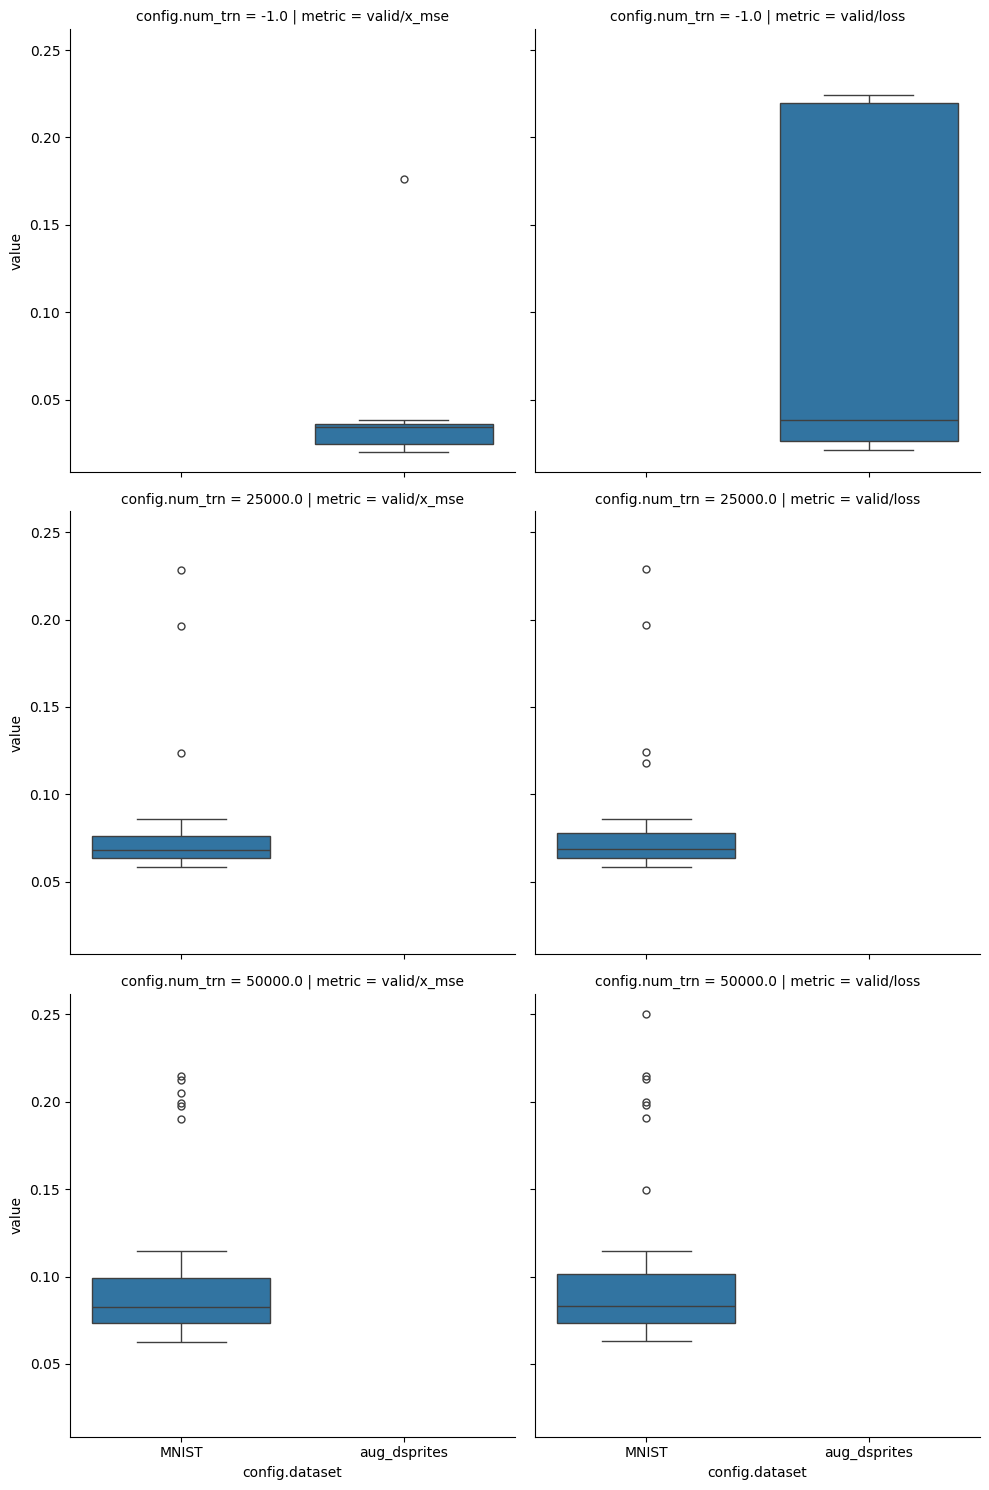

In [11]:
plot_df = df_filtered[[
    'summary.valid/x_mse', 'summary.valid/loss', 'config.angle',  'config.num_trn', 'config.dataset'
]]

# take only some settings
# plot_df = plot_df[
#     plot_df['config.init_lr'].isin([0.0003])
# ]

# pivot the data frame so that each of metrics is a column, and the values are the corresponding values
plot_df = plot_df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'],
    value_vars=['summary.valid/x_mse', 'summary.valid/loss'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')


sns.catplot(data=plot_df, x="config.dataset", y="value", col="metric", row='config.num_trn', kind="box", showfliers=True, sharey=True)

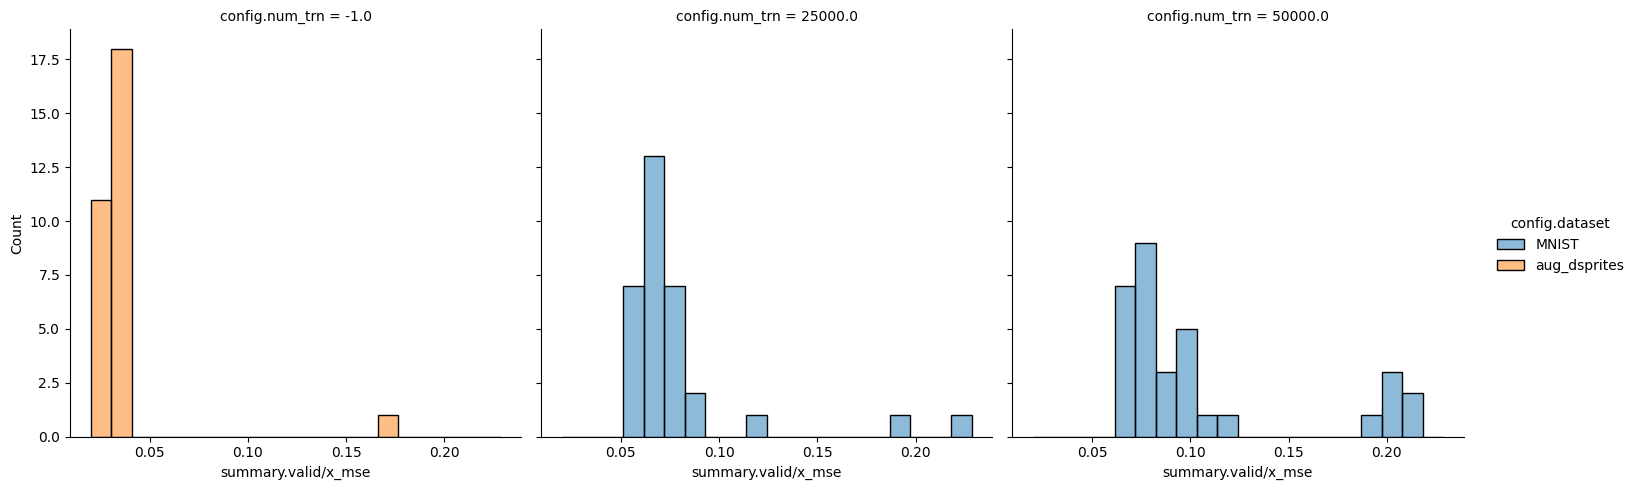

In [12]:
plot_df = df_filtered[[
    'summary.valid/x_mse', 'config.dataset', 'config.num_trn', 'config.angle'
]]

g = sns.displot(data=plot_df, x="summary.valid/x_mse", hue='config.dataset', col='config.num_trn', kind='hist', bins=20)

g

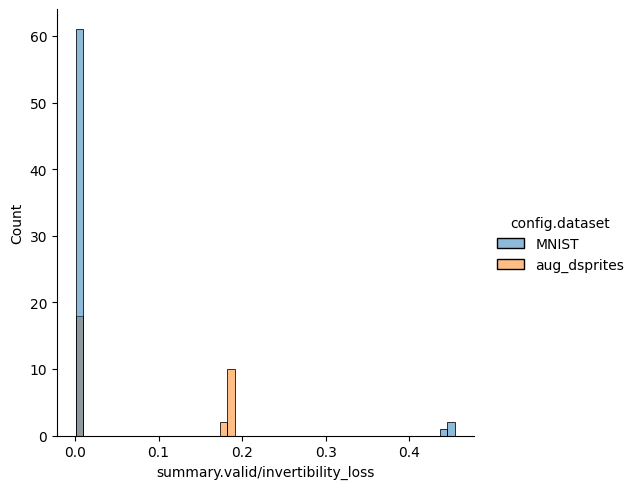

In [13]:
# plot the histograms of summary.valid/invertibility_loss for each dataset
plot_df = df_filtered[[
    'summary.valid/invertibility_loss', 'config.dataset'
]]

g = sns.displot(data=plot_df, x="summary.valid/invertibility_loss", hue='config.dataset', kind='hist', bins=50)

g

In [14]:
hyper_names = ['config.' + x for x in [
    'blur_end_pct', 'blur_filter_size', 'blur_σ_init', 'clip_norm',
    'final_lr_mult', 'init_lr_mult', 'invertibility_loss_mult', 'lr', 'model.use_layernorm',
    'n_samples',  'pred_σ_init', 'steps', 'warmup_steps_pct', 'weight_decay', 'σ_lr',
]]

In [15]:
# create a new dataframe to investigate bad inv losses
inv_loss_df = df_filtered[df_filtered['config.dataset'] == 'aug_dsprites'].copy()

# create a new column which indicates whether the invertability loss is greater than 0.1 for aug_dsprites or greater than 0.2 for mnist
inv_loss_df['bad_invertability_loss'] = inv_loss_df['summary.valid/invertibility_loss'].apply(lambda x: x > 0.1)

inv_loss_df.head()

,name,tags,id,state,sweep,summary.σ,summary.train/η_recon_loss,summary._runtime,summary.grad_norm,summary._timestamp,summary.train/invertibility_loss,summary._step,summary.lr_inf,summary.valid/η_recon_loss,summary.valid/label_paired_image_mse,summary.valid/invertibility_loss,summary.train/loss,summary.valid/x_mse,summary.lr_σ,summary.valid/loss,summary.train/x_mse,summary.blur_sigma,summary.invertibility_loss_mult,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary.inf_plots_2.height,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_training_metrics.path,summary.inf_training_metrics.size,summary.inf_training_metrics._type,summary.inf_training_metrics.width,summary.inf_training_metrics.format,summary.inf_training_metrics.height,summary.inf_training_metrics.sha256,summary.inf_plots_4.size,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_3._type,summary.inf_plots_3.width,summary.inf_plots_3.format,summary.inf_plots_3.height,summary.inf_plots_3.sha256,summary.inf_plots_3.path,summary.inf_plots_3.size,summary.inf_plots_5._type,summary.inf_plots_5.width,summary.inf_plots_5.format,summary.inf_plots_5.height,summary.inf_plots_5.sha256,summary.inf_plots_5.path,summary.inf_plots_5.size,summary._wandb.runtime,config.lr,config.seed,config.angle,config.steps,config.σ_lr,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.clip_norm,config.eval_freq,config.n_samples,config.val_split,config.batch_size,config.model_name,config.train_split,config.blur_end_pct,config.blur_σ_init,config.init_lr_mult,config.pred_σ_init,config.weight_decay,config.η_loss_mult,config.final_lr_mult,config.augment_bounds,config.augment_offset,config.translate_last,config.x_mse_loss_mult,config.blur_filter_size,config.warmup_steps_pct,config.interpolation_order,config.shuffle_buffer_size,config.repeat_after_batching,config.invertibility_loss_mult,config.model.hidden_dims,config.model.use_layernorm,config.model.squash_to_bounds,config.aug_dsprites.heart_distribution.scale,config.aug_dsprites.heart_distribution.x_position,config.aug_dsprites.heart_distribution.y_position,config.aug_dsprites.heart_distribution.orientation,config.aug_dsprites.heart_distribution.unnormalised_shape_prob,config.aug_dsprites.square_distribution.scale,config.aug_dsprites.square_distribution.x_position,config.aug_dsprites.square_distribution.y_position,config.aug_dsprites.square_distribution.orientation,config.aug_dsprites.square_distribution.unnormalised_shape_prob,config.aug_dsprites.ellipse_distribution.scale,config.aug_dsprites.ellipse_distribution.x_position,config.aug_dsprites.ellipse_distribution.y_position,config.aug_dsprites.ellipse_distribution.orientation,config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob,bad_invertability_loss
64,genial-sweep-30,[],n7x0wxbh,running,inf_bayes_dsprites_sweep_100,0.000019,0.576245,689.653958,1.264057,1.701691e+09,0.001267,14501,5.097821e-04,0.583232,0.019962,0.001199,0.033595,0.031727,0.006186,0.032926,0.032328,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000754,0,0.0,30000,0.002898,aug_dsprites,-1.0,NaN,"value_range(-1, 1, 0, 1)|move_key(""label_shape...",NaN,"value_range(-1, 1, 0, 1)|move_key(""label_shape...",47.622217,0.01,5,,512,inference_net,,0.100,10,0.068181,-4.600165,0.0

In [16]:
for col in inv_loss_df.columns:
    if inv_loss_df[col].dtype == bool:
        inv_loss_df[col] = inv_loss_df[col].astype(str)

inv_loss_df['config.steps'] = inv_loss_df['config.steps'].astype(str) + '_'
inv_loss_df['config.n_samples'] = inv_loss_df['config.n_samples'].astype(str) + '_'
inv_loss_df['config.blur_end_pct'] = inv_loss_df['config.blur_end_pct'].astype(str) + '_'
inv_loss_df['config.blur_filter_size'] = inv_loss_df['config.blur_filter_size'].astype(str) + '_'
inv_loss_df['config.blur_σ_init'] = inv_loss_df['config.blur_σ_init'].astype(str) + '_'
inv_loss_df['config.pred_σ_init'] = inv_loss_df['config.pred_σ_init'].astype(str) + '_'
inv_loss_df['config.invertibility_loss_mult'] = inv_loss_df['config.invertibility_loss_mult'].astype(str) + '_'

In [17]:
# pivot the data frame so that each of 'summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo', 'summary.hais_mll'
# is a column, and the values are the corresponding values
inv_loss_df = inv_loss_df.melt(
    id_vars=['bad_invertability_loss'],
    value_vars=hyper_names[:],
    var_name='hyper',
    value_name='value'
)

In [18]:
def bin_if_numeric(x):
    try:
        x = pd.to_numeric(x, errors='raise')
        return pd.qcut(x, q=3, duplicates='drop')
    except ValueError as e:
        print(e)
        return x

inv_loss_df['value_bins'] = inv_loss_df.groupby('hyper')['value'].transform(bin_if_numeric)

Unable to parse string "0.1_" at position 0
Unable to parse string "7_" at position 0
Unable to parse string "10_" at position 0
Unable to parse string "1.0_" at position 0
Unable to parse string "False" at position 0
Unable to parse string "5_" at position 0
Unable to parse string "-4.600165_" at position 0
Unable to parse string "30000_" at position 0


In [19]:
inv_loss_df.head()

,bad_invertability_loss,hyper,value,value_bins
0,False,config.blur_end_pct,0.1_,0.1_
1,True,config.blur_end_pct,0.01_,0.01_
2,True,config.blur_end_pct,0.01_,0.01_
3,False,config.blur_end_pct,0.001_,0.001_
4,True,config.blur_end_pct,0.1_,0.1_


In [20]:
len(inv_loss_df[inv_loss_df['bad_invertability_loss'] == 'True'])/len(inv_loss_df)

0.4

In [21]:
def calculate_ratio(df):
    # Assuming 'bad_invertability_loss' is the column that contains True or False
    counts = df['bad_invertability_loss'].value_counts()
    return counts.get("True", 0) / (counts.get("False", 1) + counts.get("True", 0)), (counts.get("False", 1) + counts.get("True", 0))

ratio_df = inv_loss_df.groupby(['hyper', 'value_bins']).apply(calculate_ratio).reset_index()
ratio_df.columns = ['hyper', 'value_bins', 'ratio']

# split ratio column into two: ratio and N
ratio_df[['ratio', 'N']] = pd.DataFrame(ratio_df['ratio'].tolist(), index=ratio_df.index)

ratio_df

,hyper,value_bins,ratio,N
0,config.blur_end_pct,0.001_,0.500000,4
1,config.blur_end_pct,0.01_,0.312500,16
2,config.blur_end_pct,0.1_,0.500000,10
3,config.blur_filter_size,5_,0.250000,8
4,config.blur_filter_size,7_,0.454545,22
5,config.blur_σ_init,0_,0.444444,9
6,config.blur_σ_init,10_,0.500000,4
7,config.blur_σ_init,1_,0.428571,7
8,config.blur_σ_init,3_,0.300000,10
9,config.clip_norm,"(1.04, 2.829]",0.500000,10


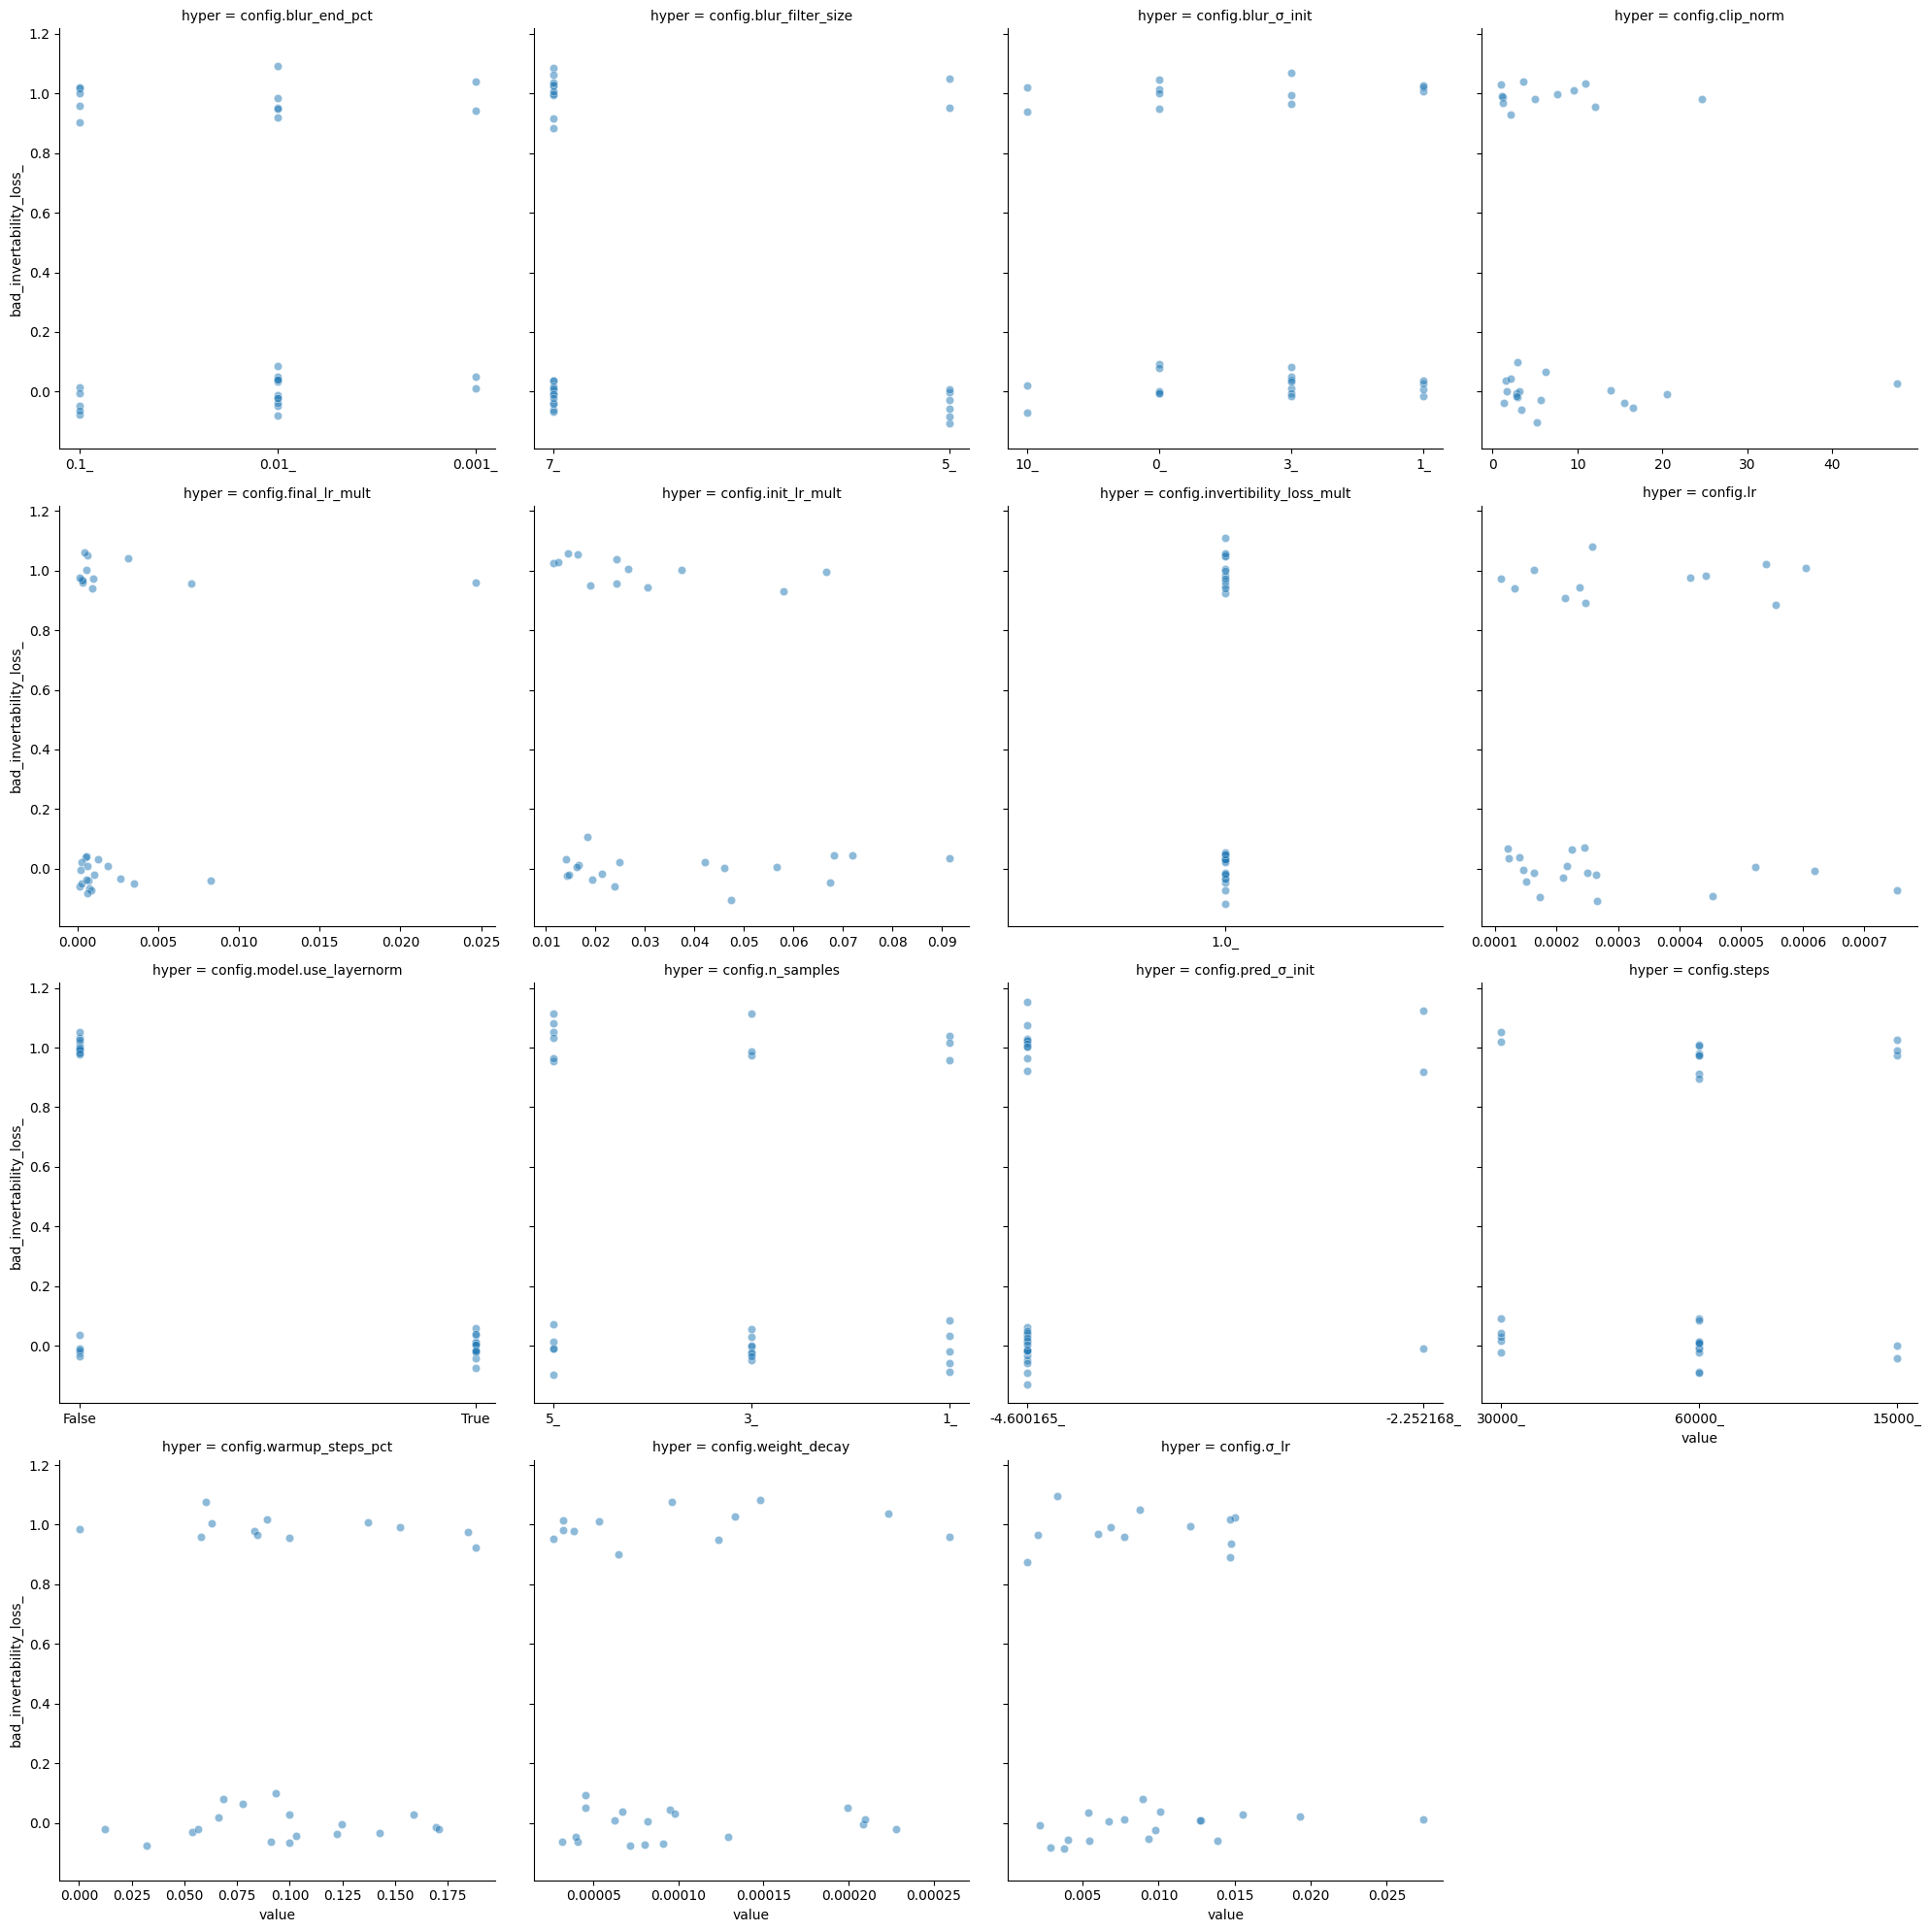

In [22]:
# add some jitter to bad_invertability_loss
inv_loss_df['bad_invertability_loss_'] = inv_loss_df['bad_invertability_loss'].apply(lambda x: float(x == 'True') + np.random.normal(0, 0.05))

g = sns.relplot(
    data=inv_loss_df,
    y="bad_invertability_loss_",
    x="value",
    col="hyper",
    col_wrap=4,
    # sharex=False, sharey=True,
    facet_kws={'sharex': False, 'sharey': True},
    alpha=0.5,
)

# g.set(xscale="log")

g

## Analize sweeps

In [23]:
df_filtered

,name,tags,id,state,sweep,summary.σ,summary.train/η_recon_loss,summary._runtime,summary.grad_norm,summary._timestamp,summary.train/invertibility_loss,summary._step,summary.lr_inf,summary.valid/η_recon_loss,summary.valid/label_paired_image_mse,summary.valid/invertibility_loss,summary.train/loss,summary.valid/x_mse,summary.lr_σ,summary.valid/loss,summary.train/x_mse,summary.blur_sigma,summary.invertibility_loss_mult,summary.inf_plots_2.sha256,summary.inf_plots_2.path,summary.inf_plots_2.size,summary.inf_plots_2._type,summary.inf_plots_2.width,summary.inf_plots_2.format,summary.inf_plots_2.height,summary.inf_plots_0.width,summary.inf_plots_0.format,summary.inf_plots_0.height,summary.inf_plots_0.sha256,summary.inf_plots_0.path,summary.inf_plots_0.size,summary.inf_plots_0._type,summary.inf_plots_1._type,summary.inf_plots_1.width,summary.inf_plots_1.format,summary.inf_plots_1.height,summary.inf_plots_1.sha256,summary.inf_plots_1.path,summary.inf_plots_1.size,summary.inf_training_metrics.path,summary.inf_training_metrics.size,summary.inf_training_metrics._type,summary.inf_training_metrics.width,summary.inf_training_metrics.format,summary.inf_training_metrics.height,summary.inf_training_metrics.sha256,summary.inf_plots_4.size,summary.inf_plots_4._type,summary.inf_plots_4.width,summary.inf_plots_4.format,summary.inf_plots_4.height,summary.inf_plots_4.sha256,summary.inf_plots_4.path,summary.inf_plots_3._type,summary.inf_plots_3.width,summary.inf_plots_3.format,summary.inf_plots_3.height,summary.inf_plots_3.sha256,summary.inf_plots_3.path,summary.inf_plots_3.size,summary.inf_plots_5._type,summary.inf_plots_5.width,summary.inf_plots_5.format,summary.inf_plots_5.height,summary.inf_plots_5.sha256,summary.inf_plots_5.path,summary.inf_plots_5.size,summary._wandb.runtime,config.lr,config.seed,config.angle,config.steps,config.σ_lr,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.clip_norm,config.eval_freq,config.n_samples,config.val_split,config.batch_size,config.model_name,config.train_split,config.blur_end_pct,config.blur_σ_init,config.init_lr_mult,config.pred_σ_init,config.weight_decay,config.η_loss_mult,config.final_lr_mult,config.augment_bounds,config.augment_offset,config.translate_last,config.x_mse_loss_mult,config.blur_filter_size,config.warmup_steps_pct,config.interpolation_order,config.shuffle_buffer_size,config.repeat_after_batching,config.invertibility_loss_mult,config.model.hidden_dims,config.model.use_layernorm,config.model.squash_to_bounds,config.aug_dsprites.heart_distribution.scale,config.aug_dsprites.heart_distribution.x_position,config.aug_dsprites.heart_distribution.y_position,config.aug_dsprites.heart_distribution.orientation,config.aug_dsprites.heart_distribution.unnormalised_shape_prob,config.aug_dsprites.square_distribution.scale,config.aug_dsprites.square_distribution.x_position,config.aug_dsprites.square_distribution.y_position,config.aug_dsprites.square_distribution.orientation,config.aug_dsprites.square_distribution.unnormalised_shape_prob,config.aug_dsprites.ellipse_distribution.scale,config.aug_dsprites.ellipse_distribution.x_position,config.aug_dsprites.ellipse_distribution.y_position,config.aug_dsprites.ellipse_distribution.orientation,config.aug_dsprites.ellipse_distribution.unnormalised_shape_prob
0,fearless-sweep-32,[],fkw511ap,finished,inf_bayes_mnist_sweep_000_25k,0.000008,0.108057,1381.256848,1.271137,1.701686e+09,0.003616,60000,3.270873e-06,0.104990,0.565036,0.003585,0.060060,0.059692,0.000933,0.060050,0.059699,0,0.1,7ff2f2ce8de6ba14e6e47c3d162225dd98e4ffa561db19...,media/images/inf_plots_2_summary_7ff2f2ce8de6b...,86965.0,image-file,1500.0,png,300.0,1500.0,png,300.0,2f1553f5e537f468ebd359d99dd7e3e394c6ade48fa16b...,media/images/inf_plots_0_summary_2f1553f5e537f...,79340.0,image-file,image-file,1500.0,png,300.0,83062c4767ac444a0533fc6cf70bcff990b530d140daaf...,media/images/inf_plots_1_summary_83062c4767ac4...,84166.0,media/images/inf_training_metrics_summary

In [312]:
mnist_condition = (df_filtered['config.dataset'] == 'MNIST') & (df_filtered['summary.valid/x_mse'] < 0.15)
aug_dsprites_condition = (df_filtered['config.dataset'] == 'aug_dsprites') & (df_filtered['summary.valid/x_mse'] < 0.15)
df_filtered_ = df_filtered[mnist_condition | aug_dsprites_condition]

# df_filtered_ = df_filtered

# df_filtered_

In [313]:
# pivot the data frame so that each of 'summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo', 'summary.hais_mll'
# is a column, and the values are the corresponding values
df = df_filtered_.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset'] + hyper_names,
    value_vars=['summary.valid/x_mse', 'summary.valid/loss', 'summary.valid/label_paired_image_mse'],
    var_name='metric',
    value_name='value'
)

df

,config.angle,config.num_trn,config.dataset,config.blur_end_pct,config.blur_filter_size,config.blur_σ_init,config.clip_norm,config.final_lr_mult,config.init_lr_mult,config.invertibility_loss_mult,config.lr,config.model.use_layernorm,config.n_samples,config.pred_σ_init,config.steps,config.warmup_steps_pct,config.weight_decay,config.σ_lr,metric,value
0,0.0,25000.0,MNIST,0.001,3,3,6.969680,0.026893,0.086949,0.1,0.000122,True,5,-4.600165,60000,0.130654,0.000010,0.002799,summary.valid/x_mse,0.059692
1,0.0,25000.0,MNIST,0.100,7,3,2.795618,0.004259,0.026522,0.1,0.000183,False,5,-4.600165,60000,0.182588,0.000011,0.002138,summary.valid/x_mse,0.065726
2,0.0,25000.0,MNIST,0.001,5,3,5.363808,0.000205,0.031583,0.1,0.000128,True,5,-4.600165,60000,0.189329,0.000243,0.001131,summary.valid/x_mse,0.060413
3,0.0,25000.0,MNIST,0.010,5,10,30.024945,0.020207,0.011378,0.1,0.000257,False,5,0.541325,60000,0.197319,0.000039,0.001925,summary.valid/x_mse,0.073033
4,0.0,25000.0,MNIST,0.001,5,10,18.603432,0.000140,0.011858,0.1,0.000105,True,5,0.541325,15000,0.138109,0.000023,0.001917,summary.valid/x_mse,0.123652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.0,-1.0,aug_dsprites,0.010,7,1,2.090753,0.000196,0.024835,1.0,0.000122,True,1,-4.600165,15000,0.093547,0.000032,0.004025,summary.valid/label_paired_image_mse,0.030589
251,0.0,-1.0,aug_dsprites,0.010,7,3,2.963494,0.000591,0.016157,1.0,0.000140,True,3,-4.600165,60000,0.103134,0.000228,0.007739,summary.valid/label_paired_image_mse,0.014457
252,0.0,-1.0,aug_dsprites,0.001,7,0,10.957748,0.024650,0.012508,1.0,0.000213,False,5,-2.252168,15000,0.000145,0.000123,0.014699,summary.valid/label_paired_image_mse,0.176084
253,0.0,-1.0,aug_dsprites,0.001,7,0,2.808199,0.001261,0.045988,1.0,0.000218,True,1,-4.600165,30000,0.056465,0.000062,0.003791,summary.valid/label_paired_image_mse,0.031786


In [314]:
print(df['config.blur_end_pct'].unique())
print(df['config.blur_filter_size'].unique())
print(df['config.blur_σ_init'].unique())

[0.001 0.1   0.01 ]
[3 7 5]
[ 3 10  0  1]


In [315]:
METRIC = 'summary.valid/x_mse'
# METRIC = 'summary.valid/label_paired_image_mse'

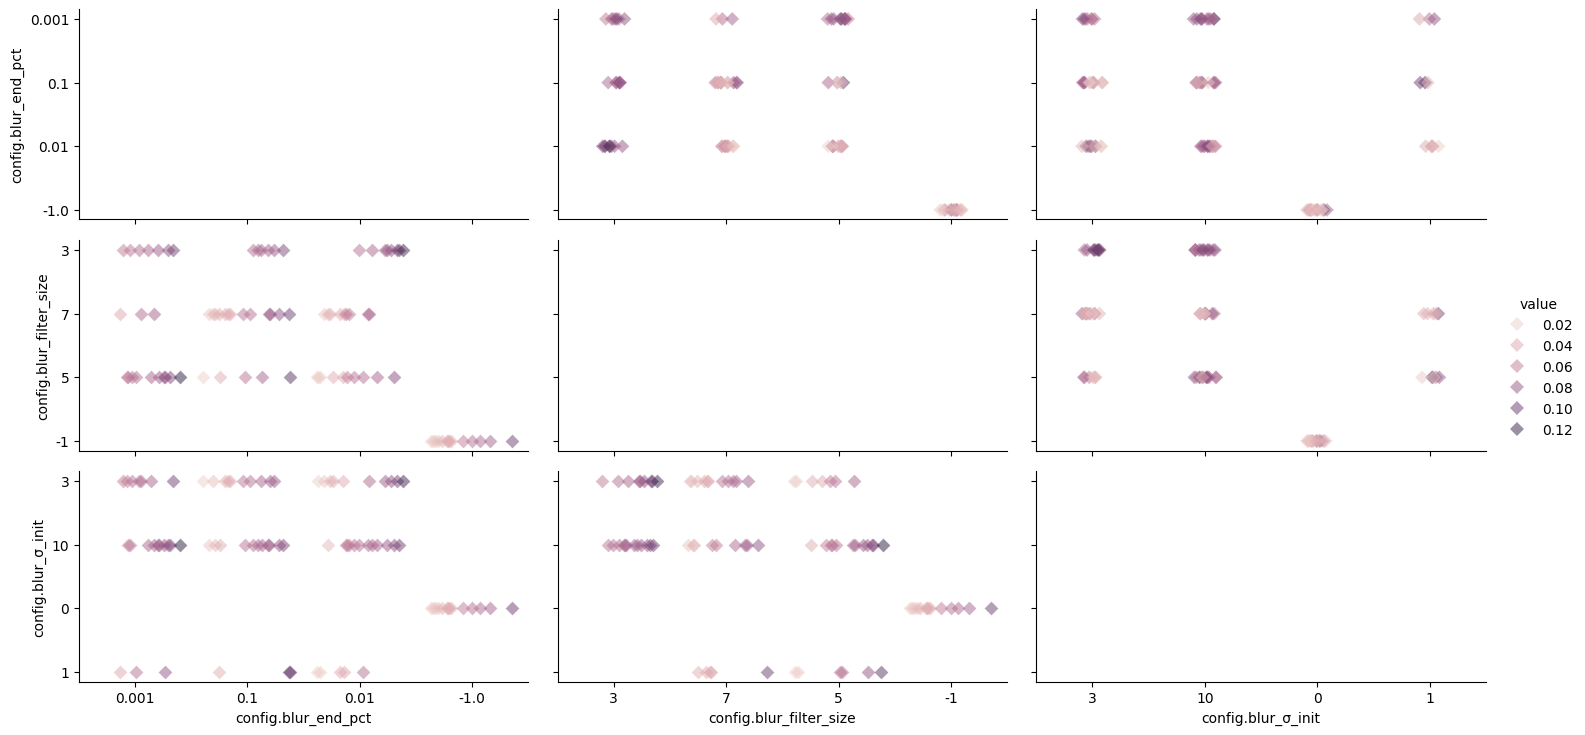

In [360]:
# for cases where config.blur_σ_init = 0, set config.blur_filter_size = -1, and config.blur_end_pct = -1
df.loc[df['config.blur_σ_init'] == 0, 'config.blur_filter_size'] = -1
df.loc[df['config.blur_σ_init'] == 0, 'config.blur_end_pct'] = -1

# set the "config.blur_end_pct", "config.blur_filter_size", "config.blur_σ_init" to be categorical
df['config.blur_end_pct'] = df['config.blur_end_pct'].astype(str)
df['config.blur_filter_size'] = df['config.blur_filter_size'].astype(str)
df['config.blur_σ_init'] = df['config.blur_σ_init'].astype(str)

g = sns.PairGrid(
    df[df.metric == METRIC],
    vars=["config.blur_end_pct", "config.blur_filter_size", "config.blur_σ_init"], 
    hue="value",
    # palette='viridis',
    aspect=2.,
)
g.map_upper(sns.stripplot, s=7, marker="D", alpha=.5,)
g.map_lower(sns.stripplot, dodge=True, s=7, marker="D", alpha=.5,)
g.add_legend()

g

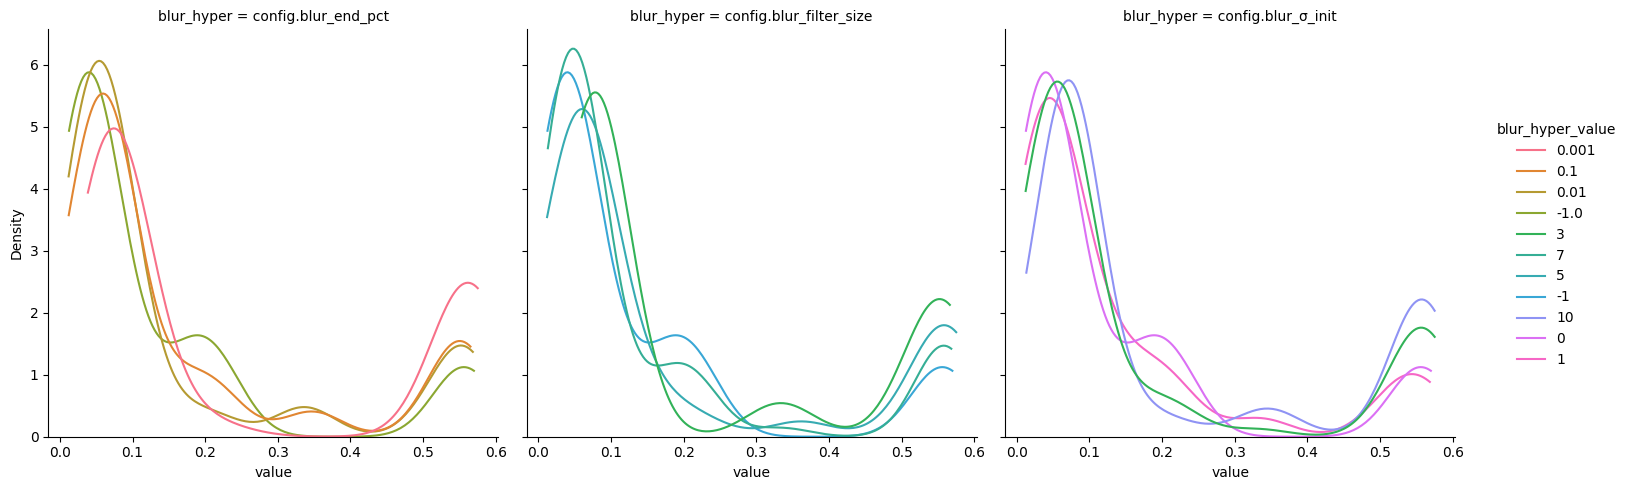

In [361]:
# pivot the tmp_df so that each of 'config.blur_end_pct', 'config.blur_filter_size', 'config.blur_σ_init'
# is a value in a new column
tmp_df = df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.dataset', 'metric', 'value'],
    value_vars=['config.blur_end_pct', 'config.blur_filter_size', 'config.blur_σ_init'],
    var_name='blur_hyper',
    value_name='blur_hyper_value'
)

sns.displot(
    tmp_df,
    x="value",
    hue="blur_hyper_value",
    col="blur_hyper",
    kind="kde",
    cut=0,
    bw_adjust=0.5,
    common_norm=False,
    # palette='viridis',
    # element="step",
    # alpha=0.5,
    # fill=False,
    # multiple="dodge"
)

### blur_end_pct

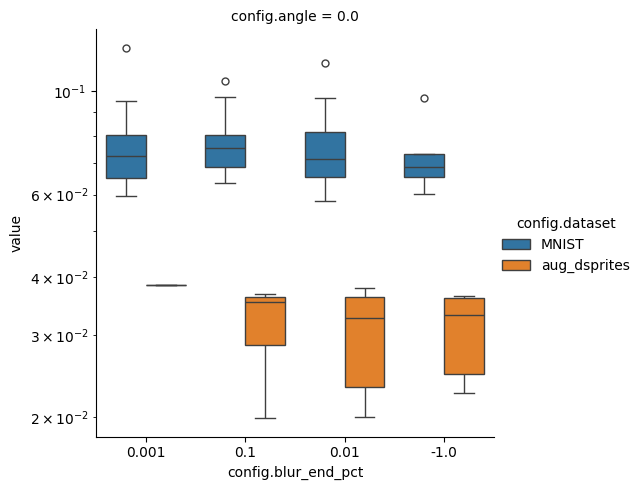

In [362]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_end_pct",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=True,
)

g.set(yscale="log")

g

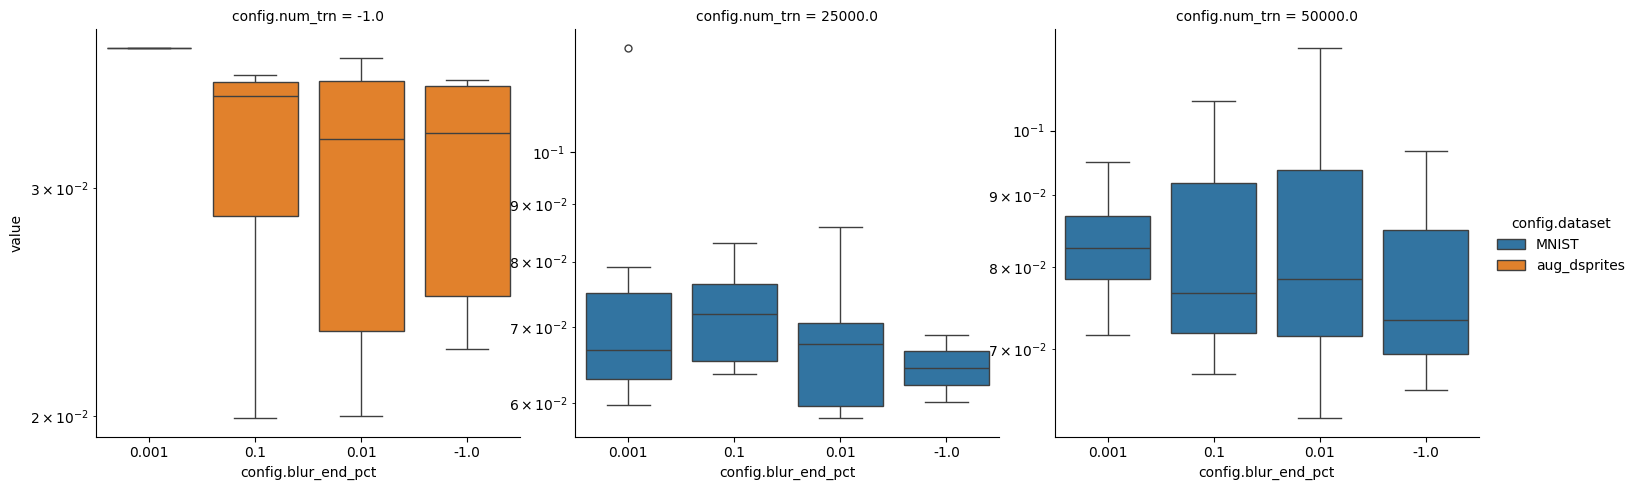

In [363]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_end_pct",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

### blur_filter_size

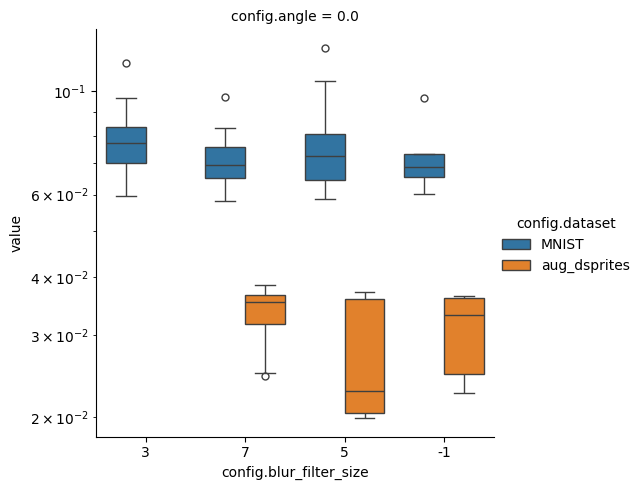

In [364]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_filter_size",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

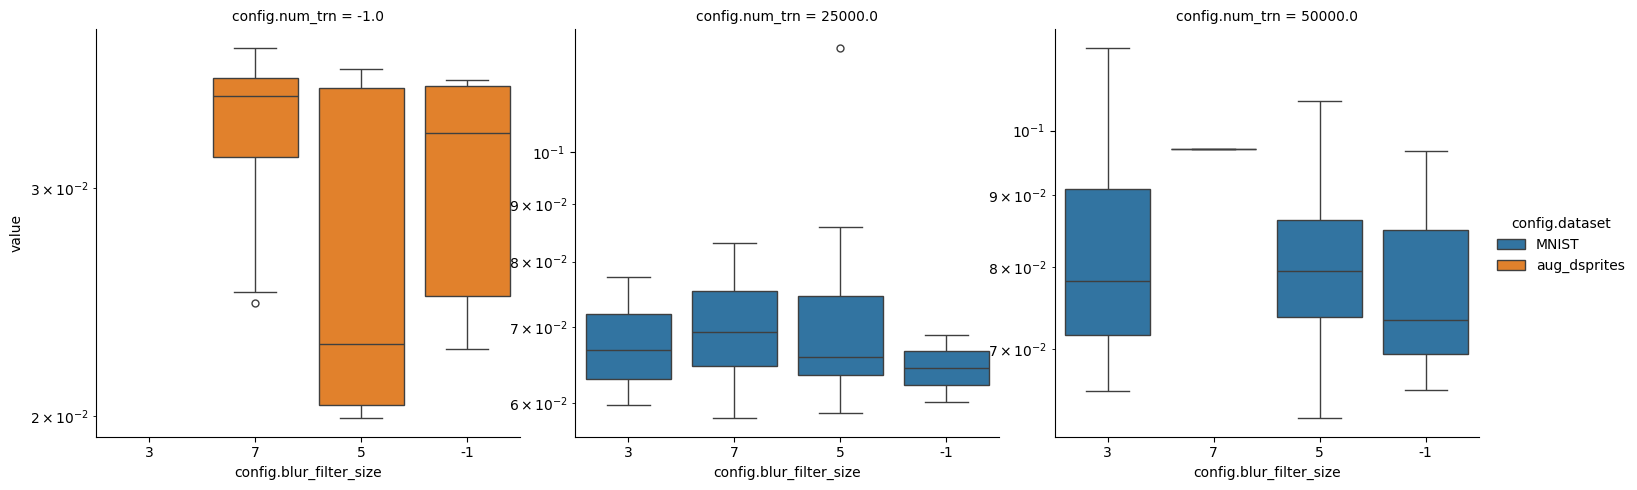

In [399]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_filter_size",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

### blur_σ_init

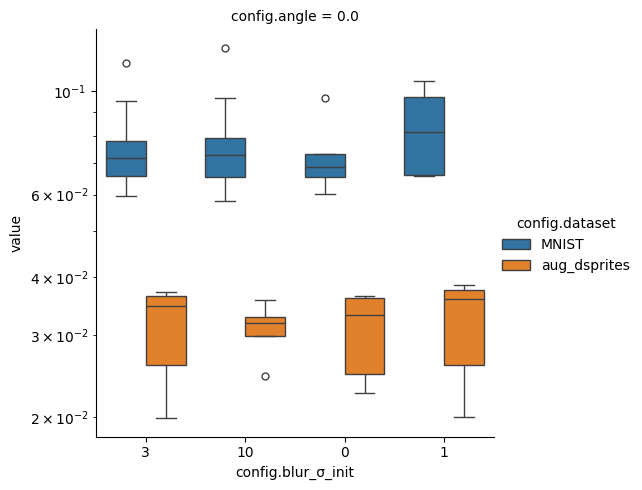

In [366]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_σ_init",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

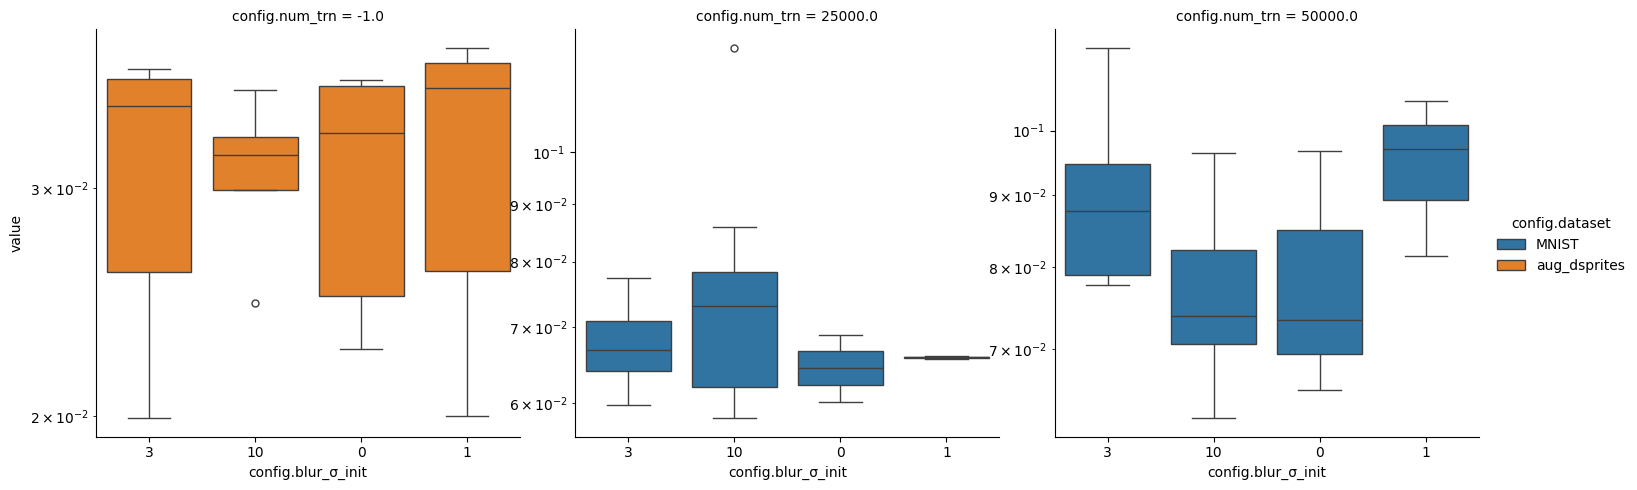

In [398]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.blur_σ_init",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

### clip_norm

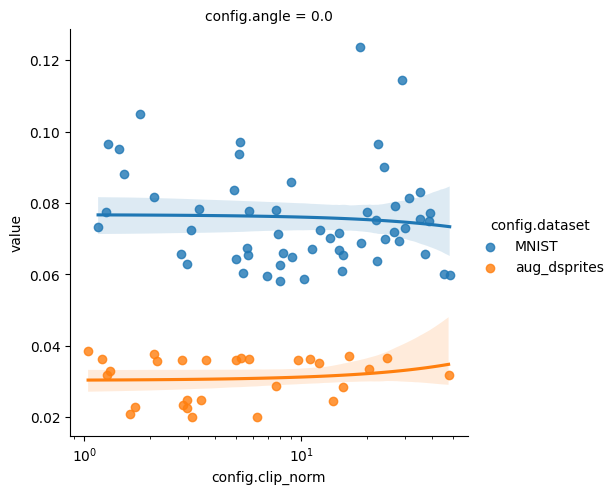

In [368]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    col="config.angle",  hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

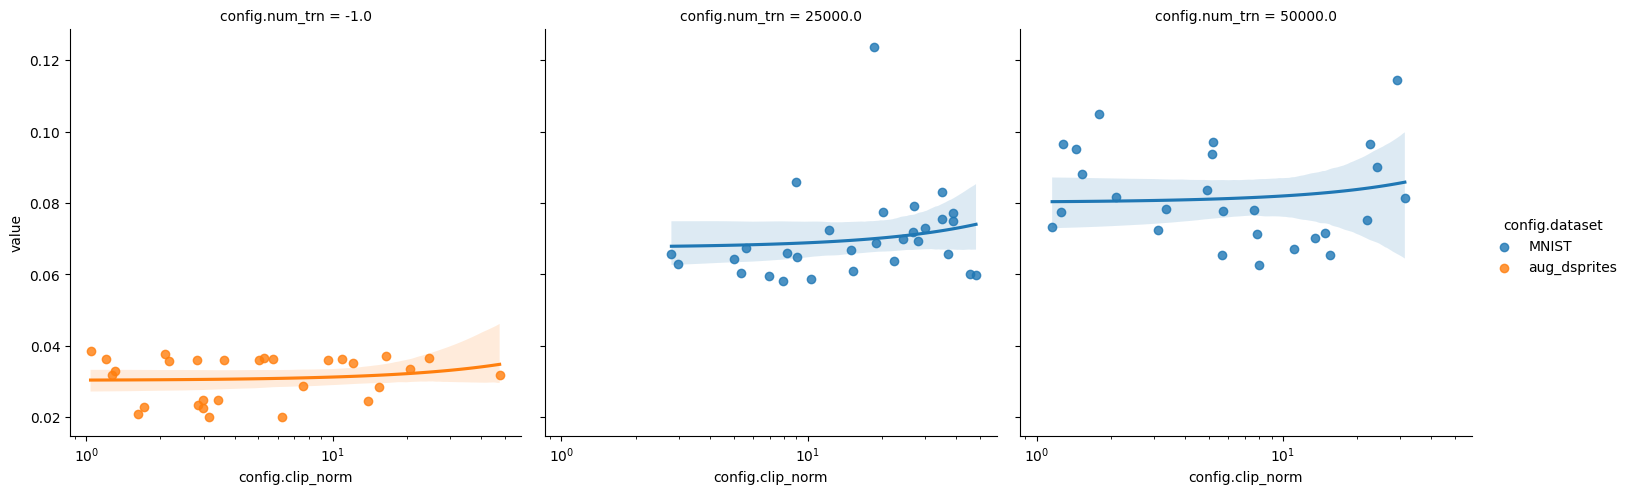

In [369]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.clip_norm",
    y="value",
    col="config.num_trn",  hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

### final_lr_mult

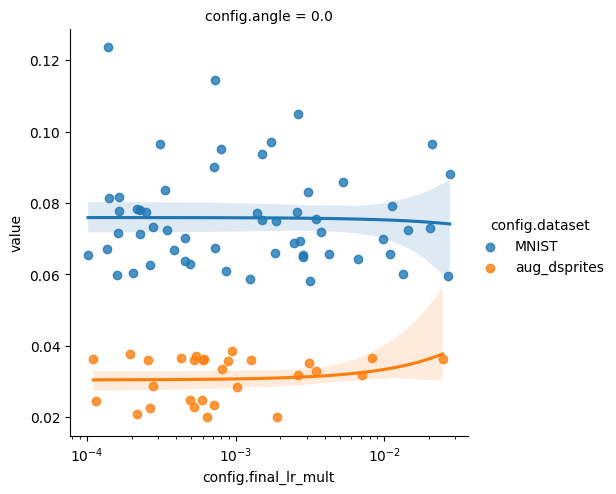

In [370]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    col="config.angle", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

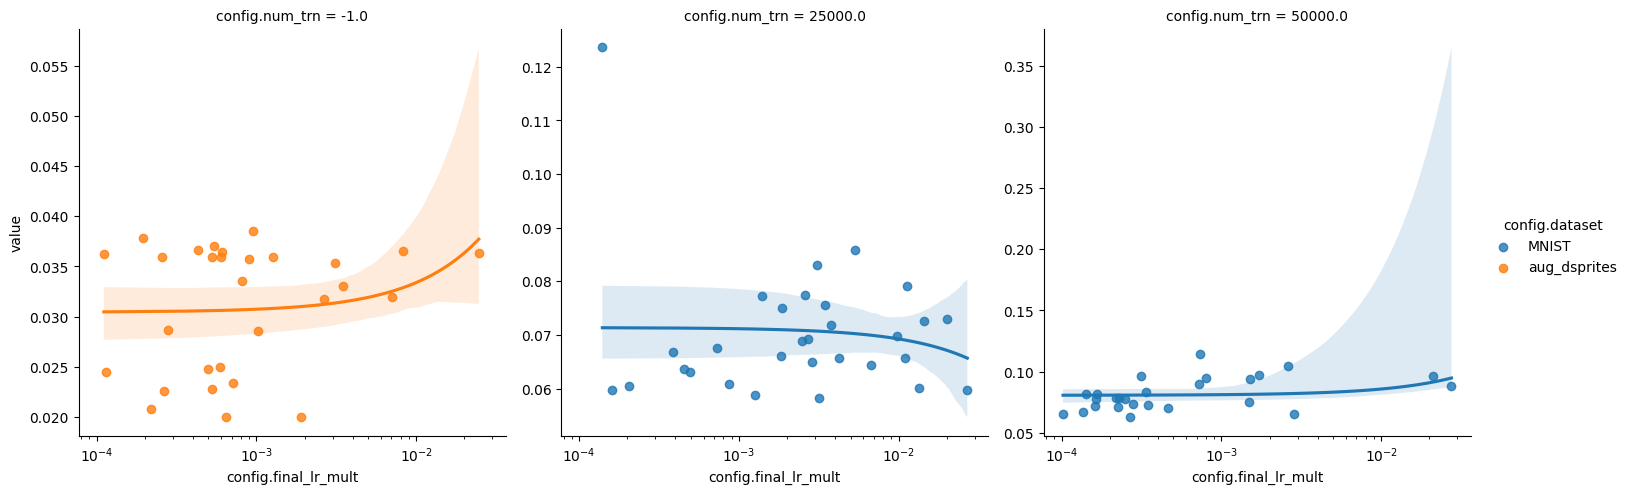

In [397]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.final_lr_mult",
    y="value",
    col="config.num_trn", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

### init_lr_mult

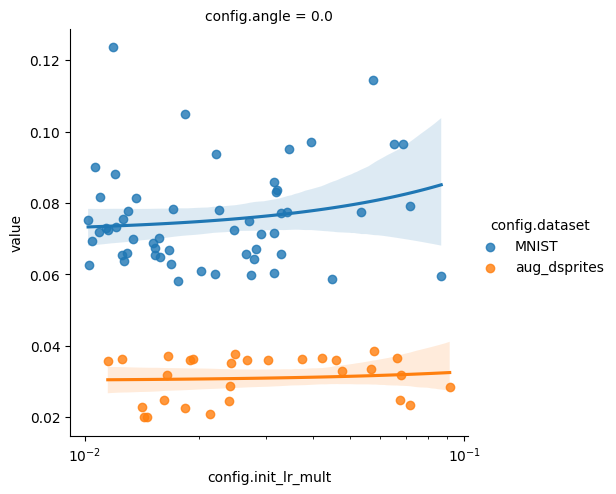

In [372]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    col="config.angle", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

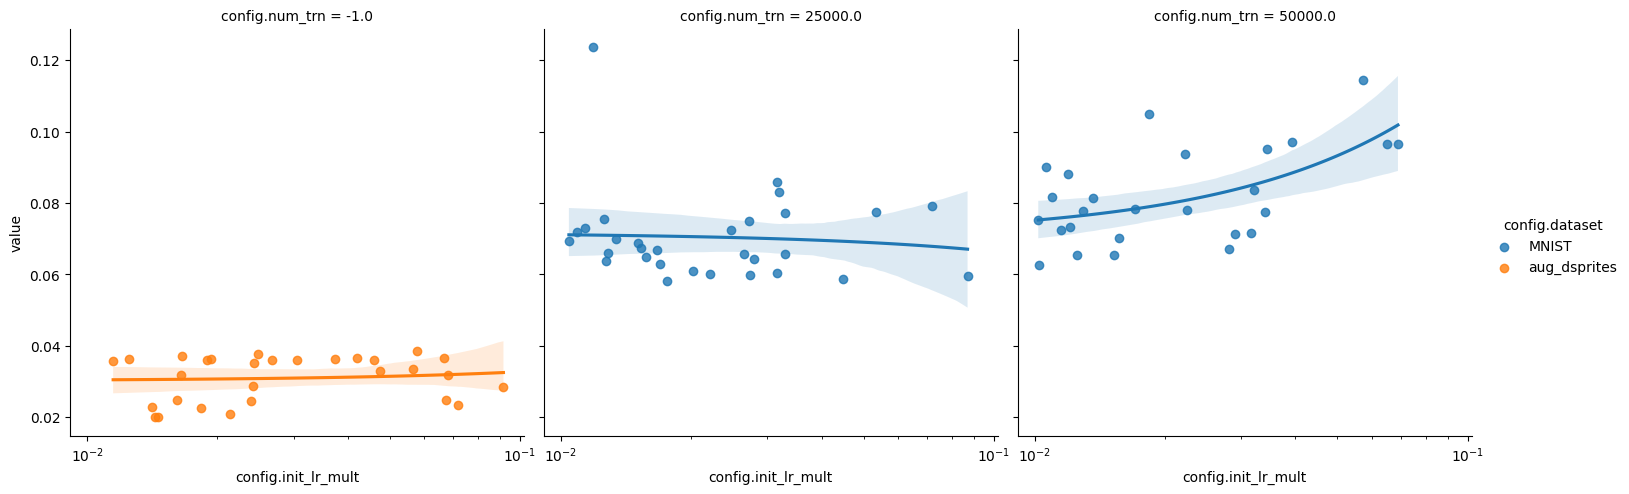

In [373]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.init_lr_mult",
    y="value",
    col="config.num_trn", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

### lr

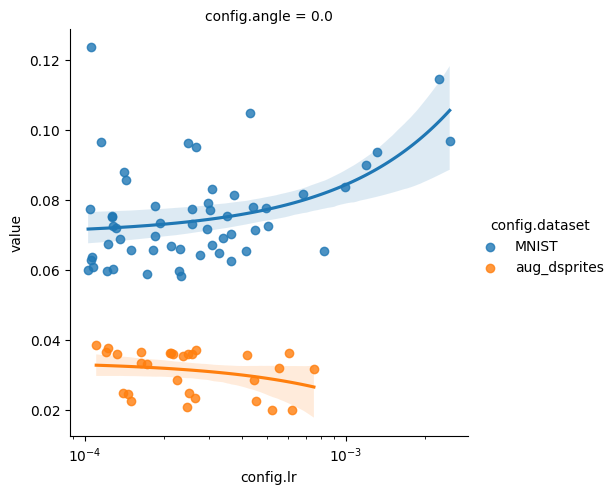

In [374]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    col="config.angle", hue='config.dataset', 
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

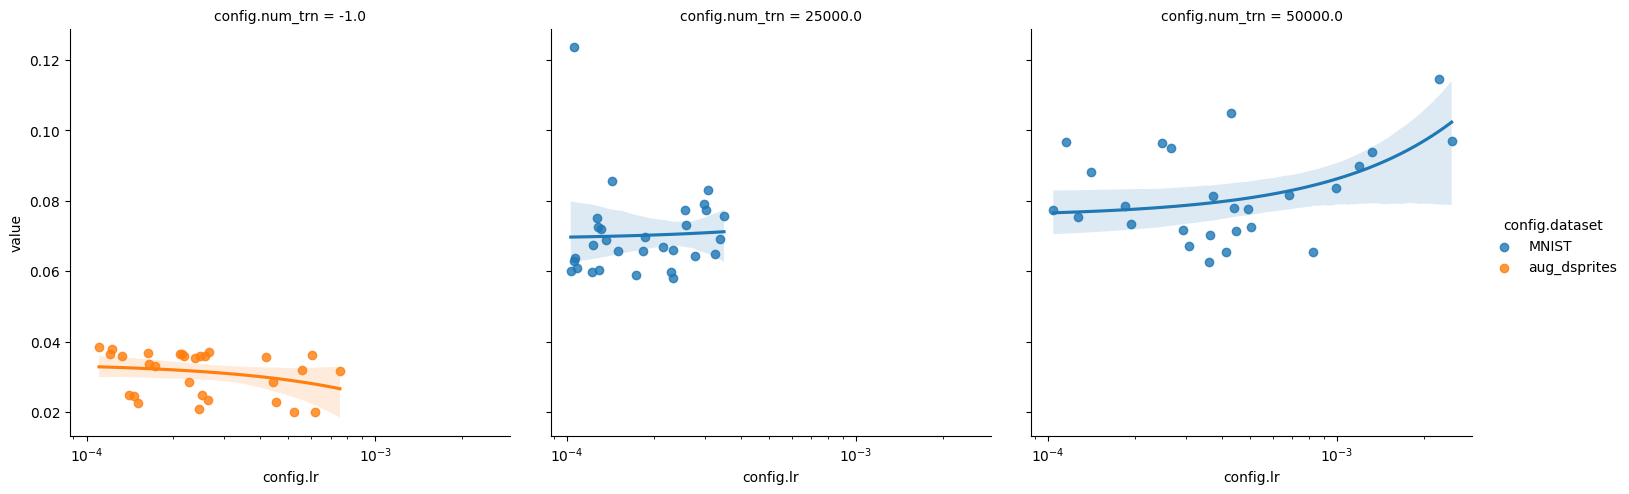

In [375]:
g = sns.lmplot(
    data=df[df.metric == METRIC],
    x="config.lr",
    y="value",
    col="config.num_trn", hue='config.dataset', 
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

### model.use_layernorm

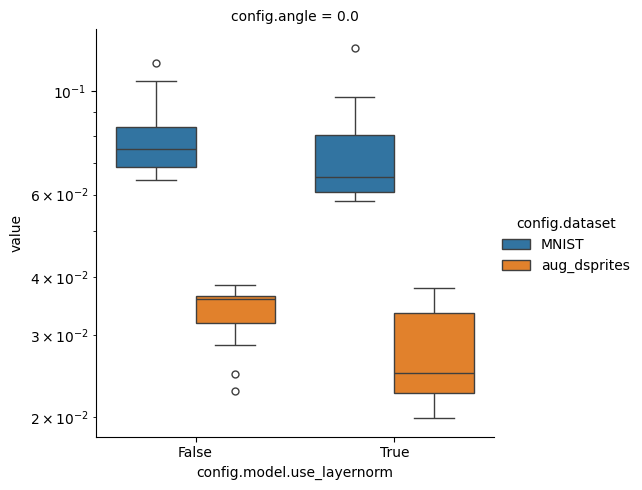

In [376]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.use_layernorm",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

g.set(yscale="log")

g

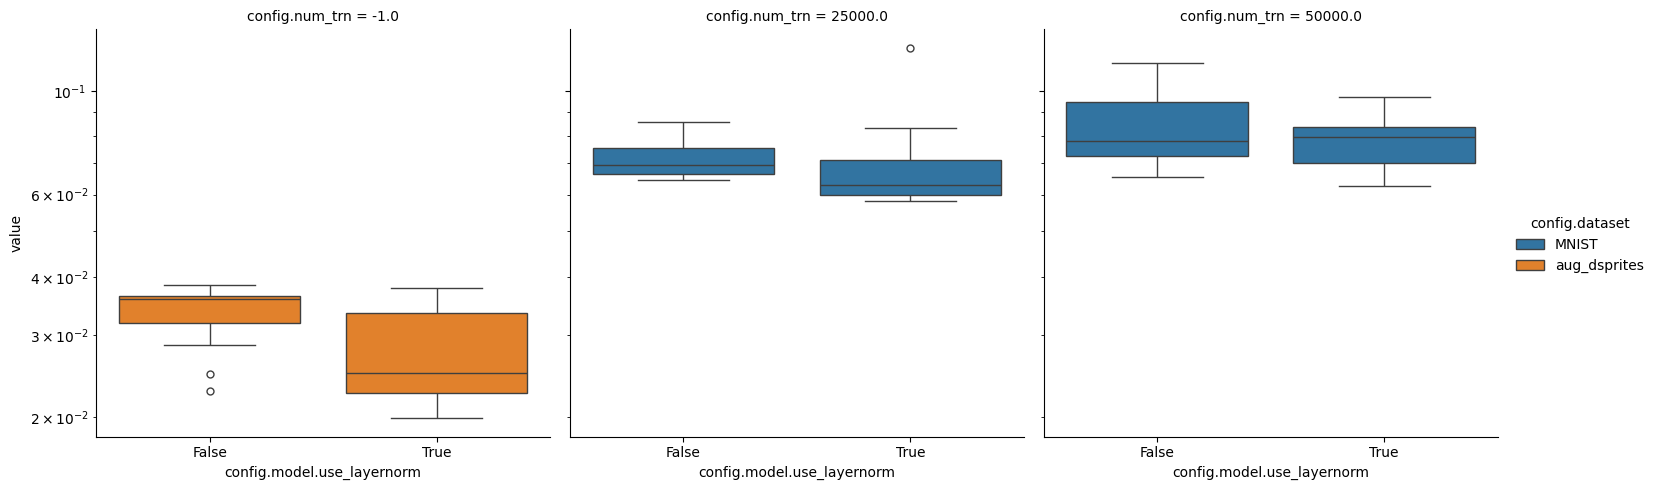

In [377]:
g = sns.catplot(
    data=df[df.metric == METRIC],
    x="config.model.use_layernorm",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=True,
)

g.set(yscale="log")

g

### n_samples

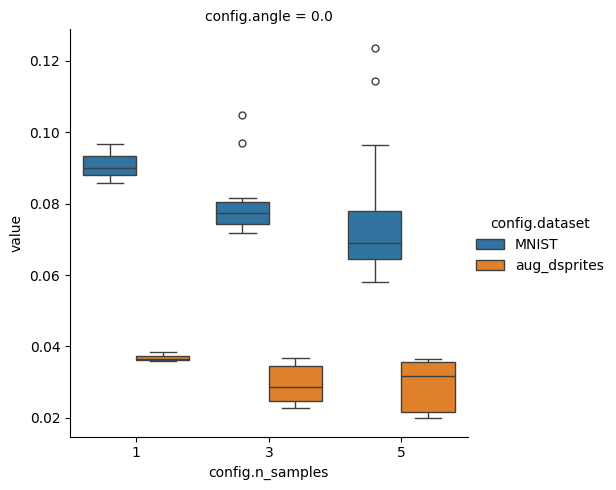

In [378]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.n_samples",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)


# g.set(yscale="log")

g

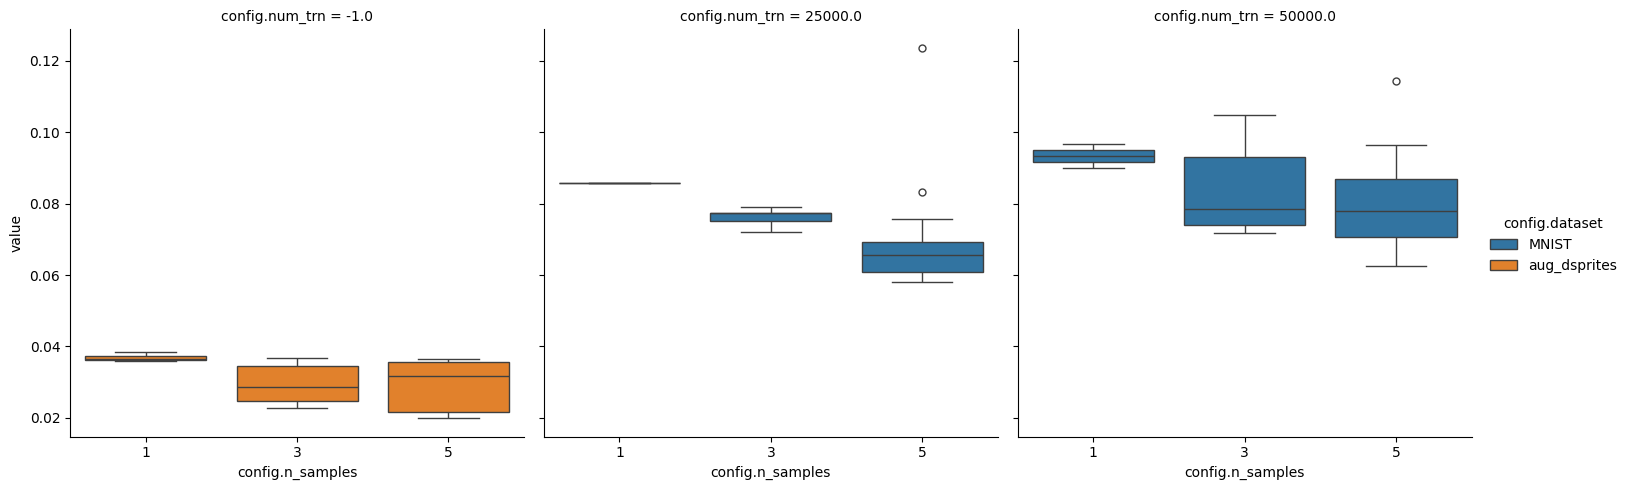

In [379]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.n_samples",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=True,
)


# g.set(yscale="log")

g

### pred_σ_init

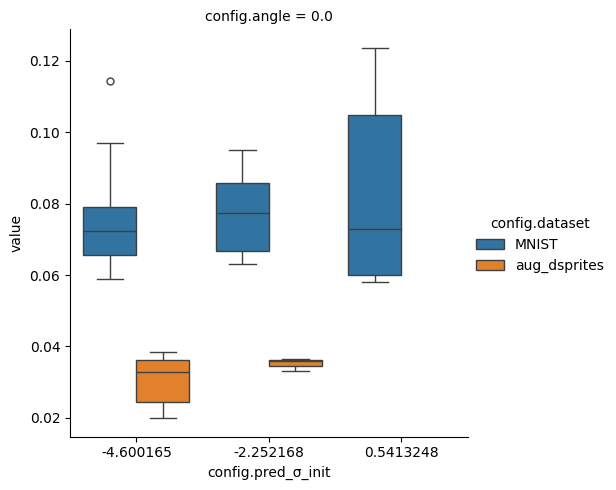

In [380]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.pred_σ_init",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

# g.set(yscale="log")

g

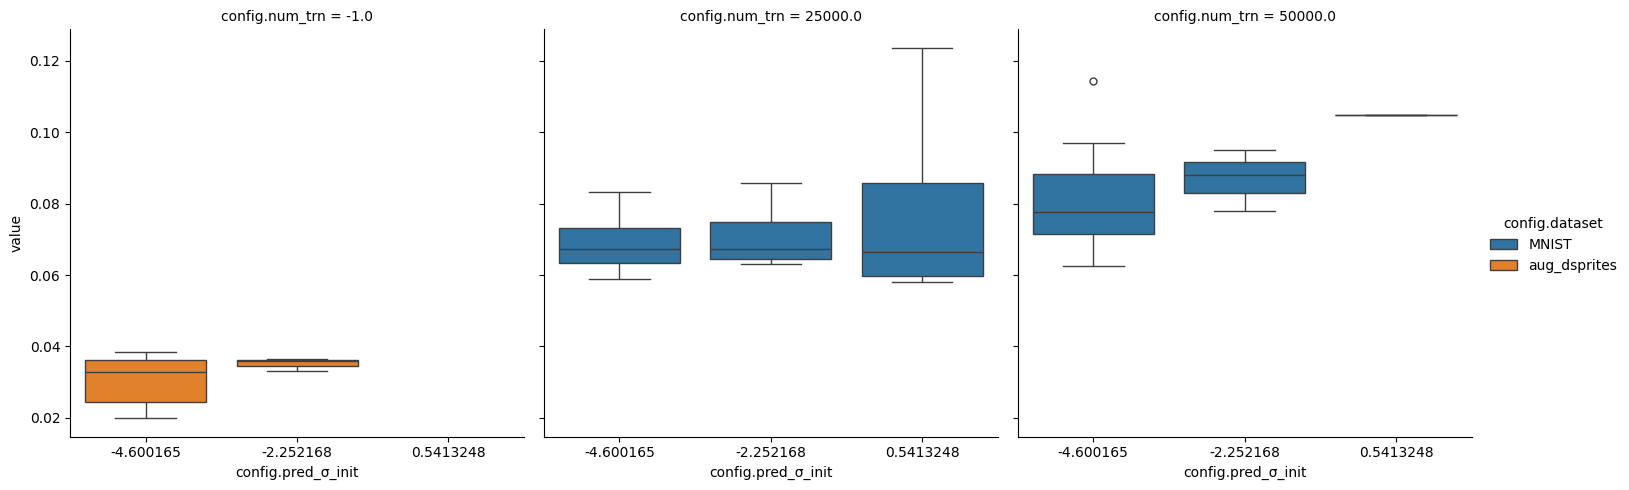

In [381]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.pred_σ_init",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=True,
)

# g.set(yscale="log")

g

### steps

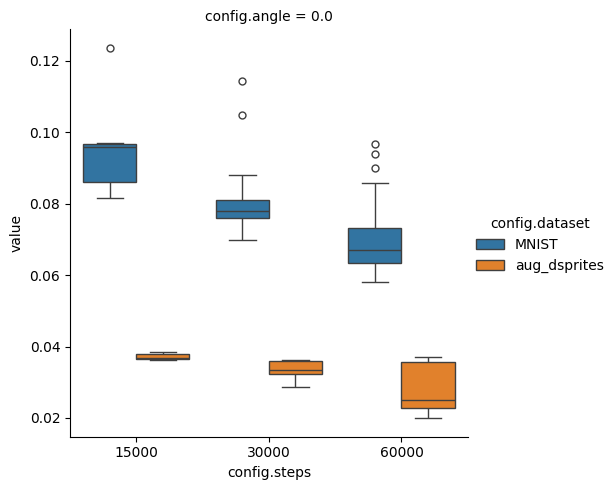

In [382]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.steps",
    y="value",
    col="config.angle", hue='config.dataset',
    kind="box",
    sharex=True, sharey=False,
)

# g.set(yscale="log")

g

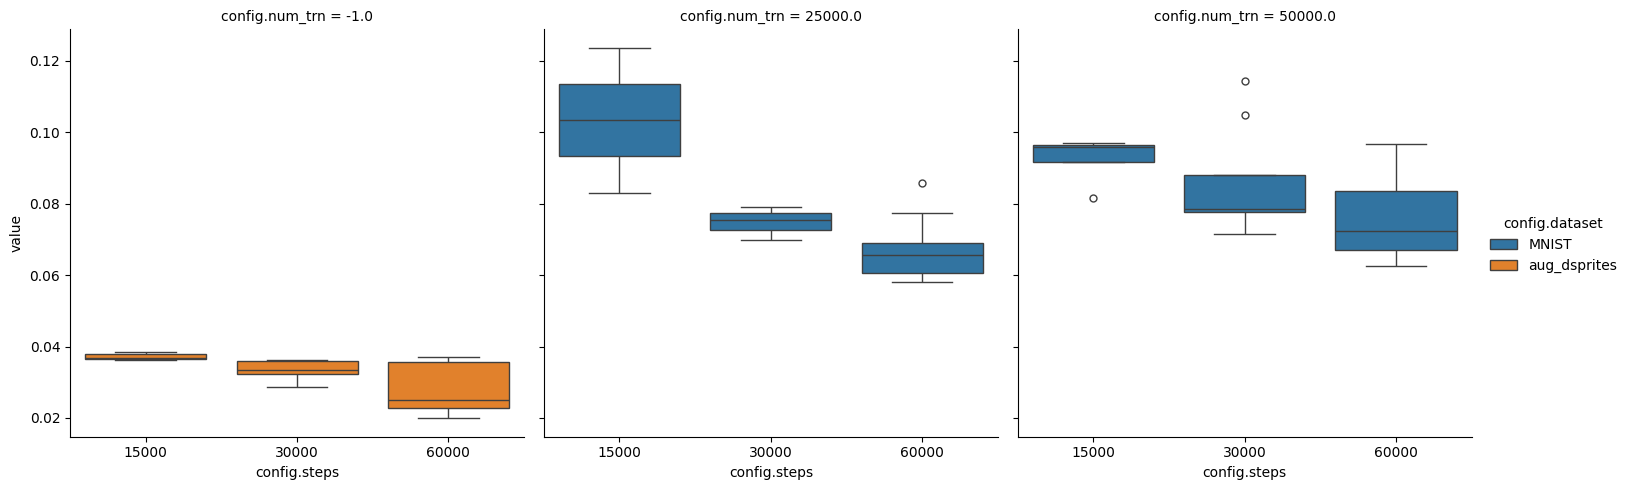

In [383]:
g = sns.catplot(
    data=df[(df.metric == METRIC)],
    x="config.steps",
    y="value",
    col="config.num_trn", hue='config.dataset',
    kind="box",
    sharex=True, sharey=True,
)

# g.set(yscale="log")

g

### warmup_steps_pct

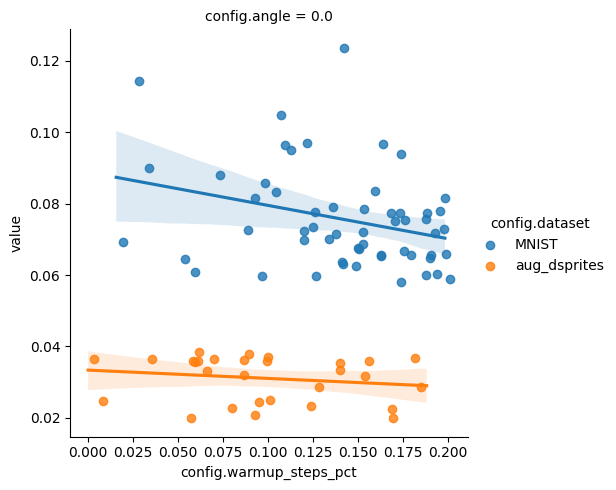

In [384]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.warmup_steps_pct",
    y="value",
    col="config.angle", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    x_jitter=0.005,
    order=1
)

# g.set(yscale="log")

g

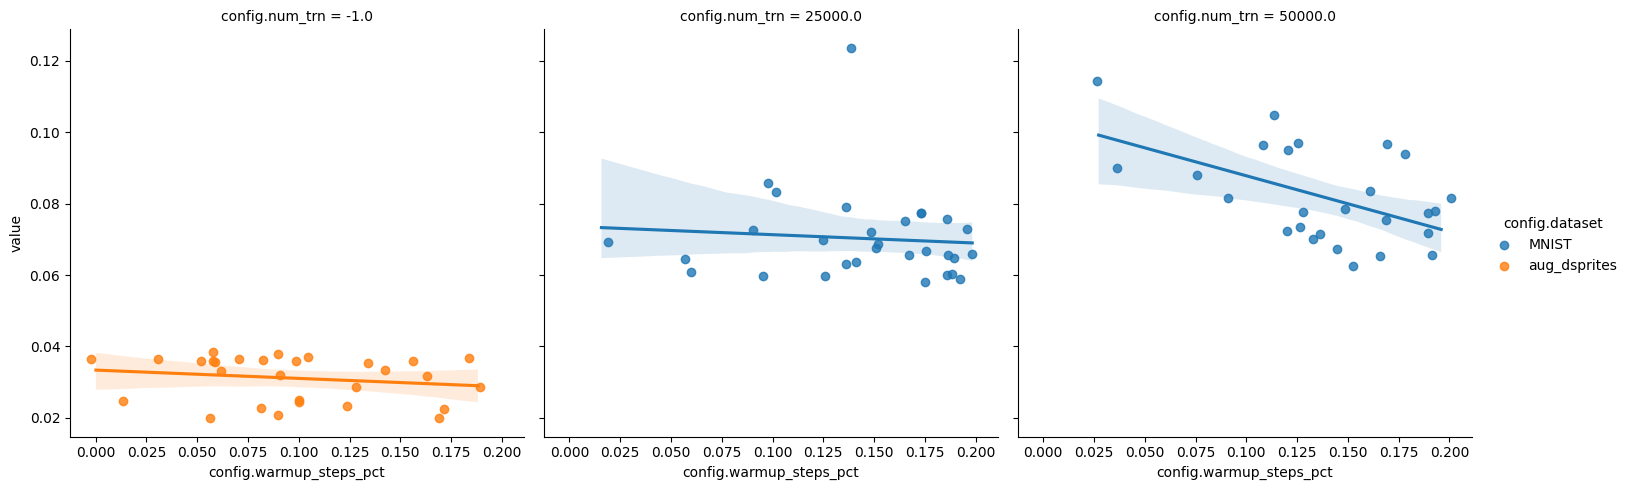

In [385]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.warmup_steps_pct",
    y="value",
    col="config.num_trn", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    x_jitter=0.005,
    order=1
)

# g.set(yscale="log")

g

### weight_decay

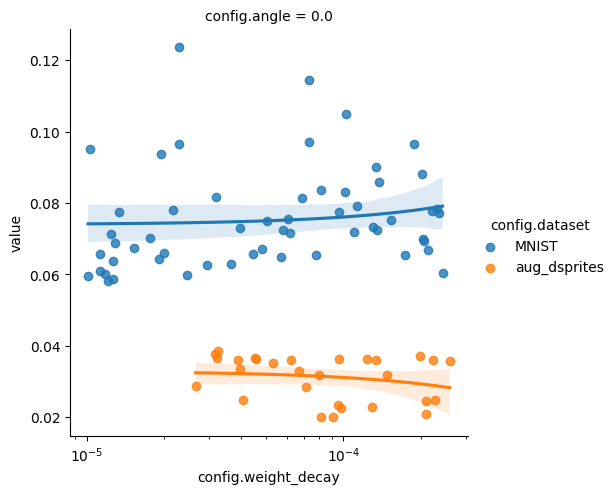

In [386]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.weight_decay",
    y="value",
    col="config.angle", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

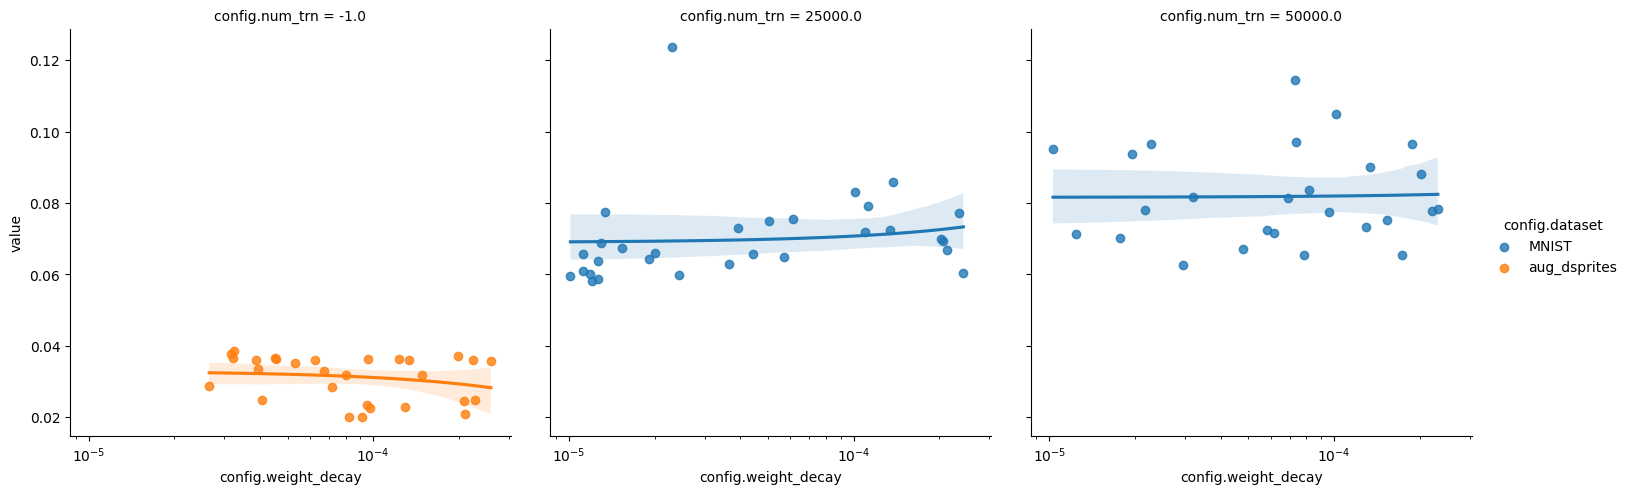

In [387]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.weight_decay",
    y="value",
    col="config.num_trn", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log")

g

### σ_lr

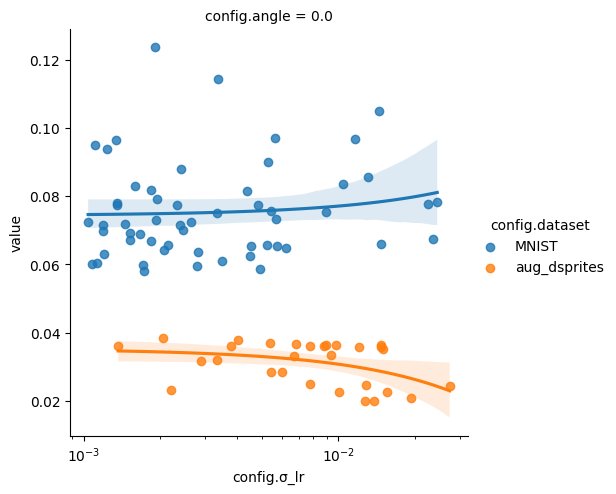

In [392]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.σ_lr",
    y="value",
    col="config.angle", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log",)

g

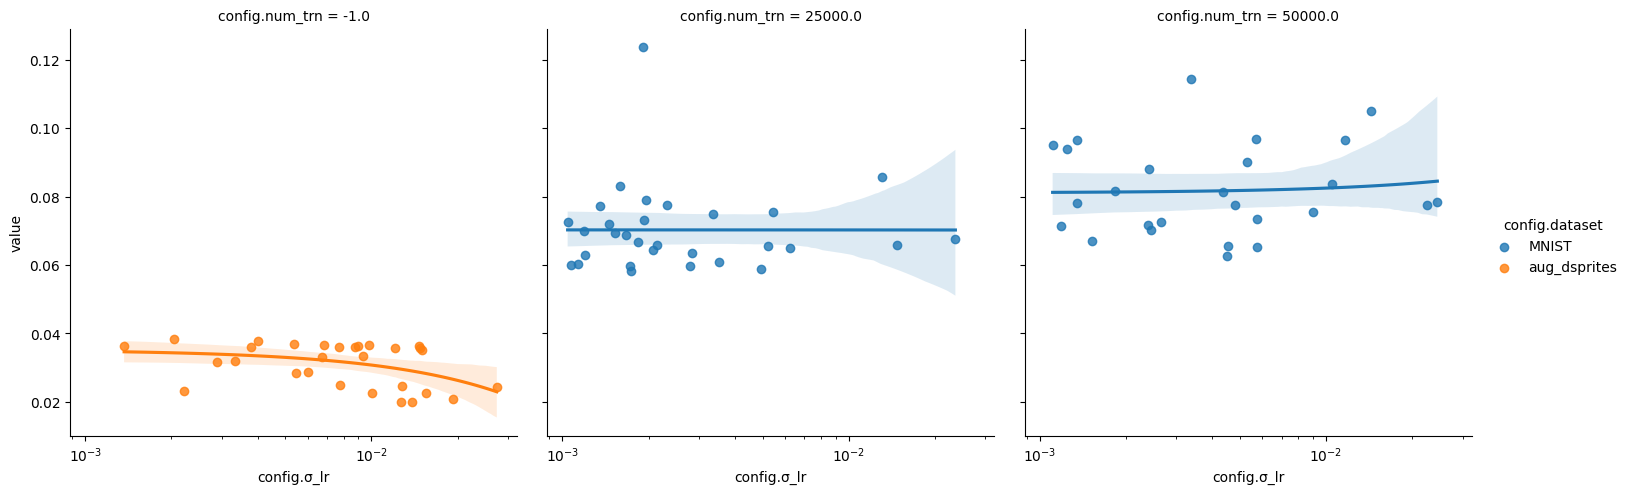

In [393]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.σ_lr",
    y="value",
    col="config.num_trn", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': True},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log",)

g

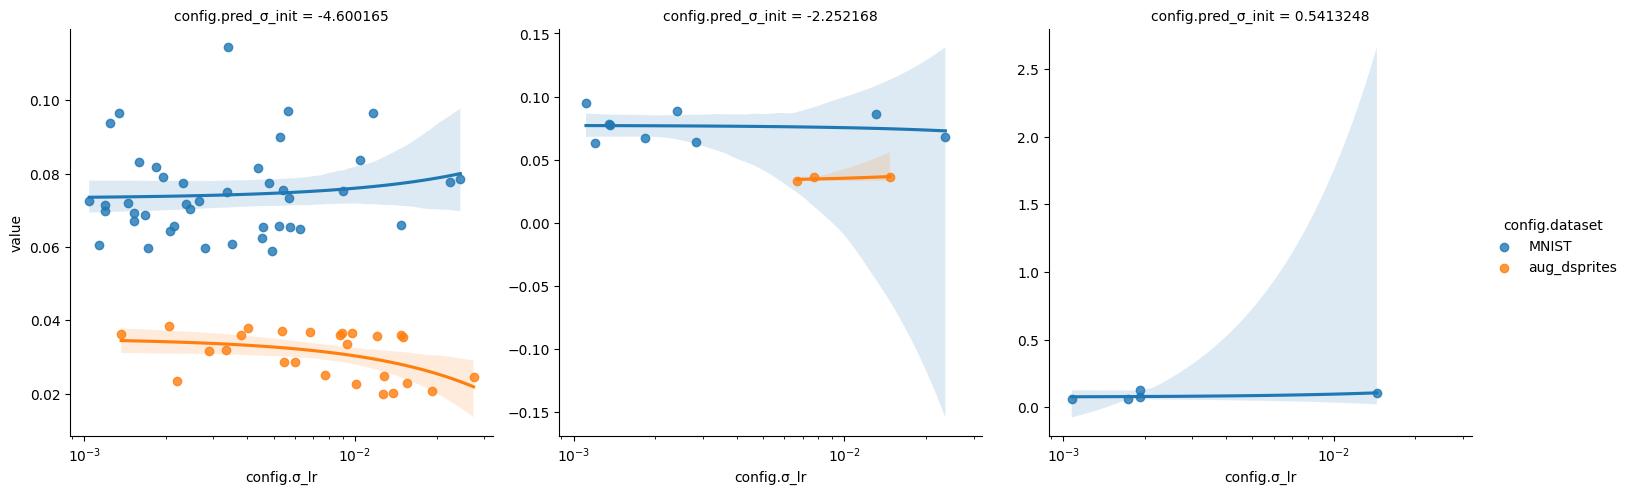

In [396]:
g = sns.lmplot(
    data=df[(df.metric == METRIC)],
    x="config.σ_lr",
    y="value",
    col="config.pred_σ_init", hue='config.dataset',
    # kind="scatter",
    facet_kws={'sharex': True, 'sharey': False},
    # x_jitter=0.05,
    order=1
)

g.set(xscale="log",)

g